# 3. Statistical Inference and Frequentist A/B Testing
If you went through my **Introduction to Statistics** post, then you are finally arriving at the payoff for all of our work: **statistical inference**. Statistical inference is used a wide variety of ways, but for now we will informally describe it as follows:

> Statistics cannot prove anything with certainty. Instead, statistical inference derives its power from observing some pattern or outcome and then using probability to determine the most likely explanation for that outcome. 

To demonstrate with an extreme example, imagine that you have a friend who makes you the following bet: he has a 10 sided die, and bets you that if he rolls a 9 you pay him 1000 and if he rolls anything else you pay him 1000. He then proceeds to roll eight 9's in a row, forcing you to pay him 8000. One possibility is that he was incredibly lucky, the other that he cheated. The probability of rolling eight 9's in a row with a 10 sided die is one in one hundred million. Again, there may be no way to prove with 100% certainty that he cheated, but we should definitely investigate the die. 

The intuition that you had above that told you he most likely cheated, in a sense statistical inference is the building of that intuition into a mathematical framework, allowing us to quantify probabilities surrounding decisions. 

Let's consider a much more important scenario that comes into play frequently in the fields of medicine and epidemiology. Imagine there is a new heart medication on the market, and there is a **randomized controlled trial** to determine its effectiveness. Let's say that 52 out of 100 patients taking the new medication showed improvement compared to 49 of 100 patients who had the placebo (plot on left). In this case we would not be able to immediately conclude that the new drug is effective, since it easily _explained_ by chance variation between the two groups.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc, animation
import numpy as np
from scipy.stats import norm
from scipy import stats
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML

sns.set(style="white", palette="husl")
sns.set_context("talk")
sns.set_style("ticks")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

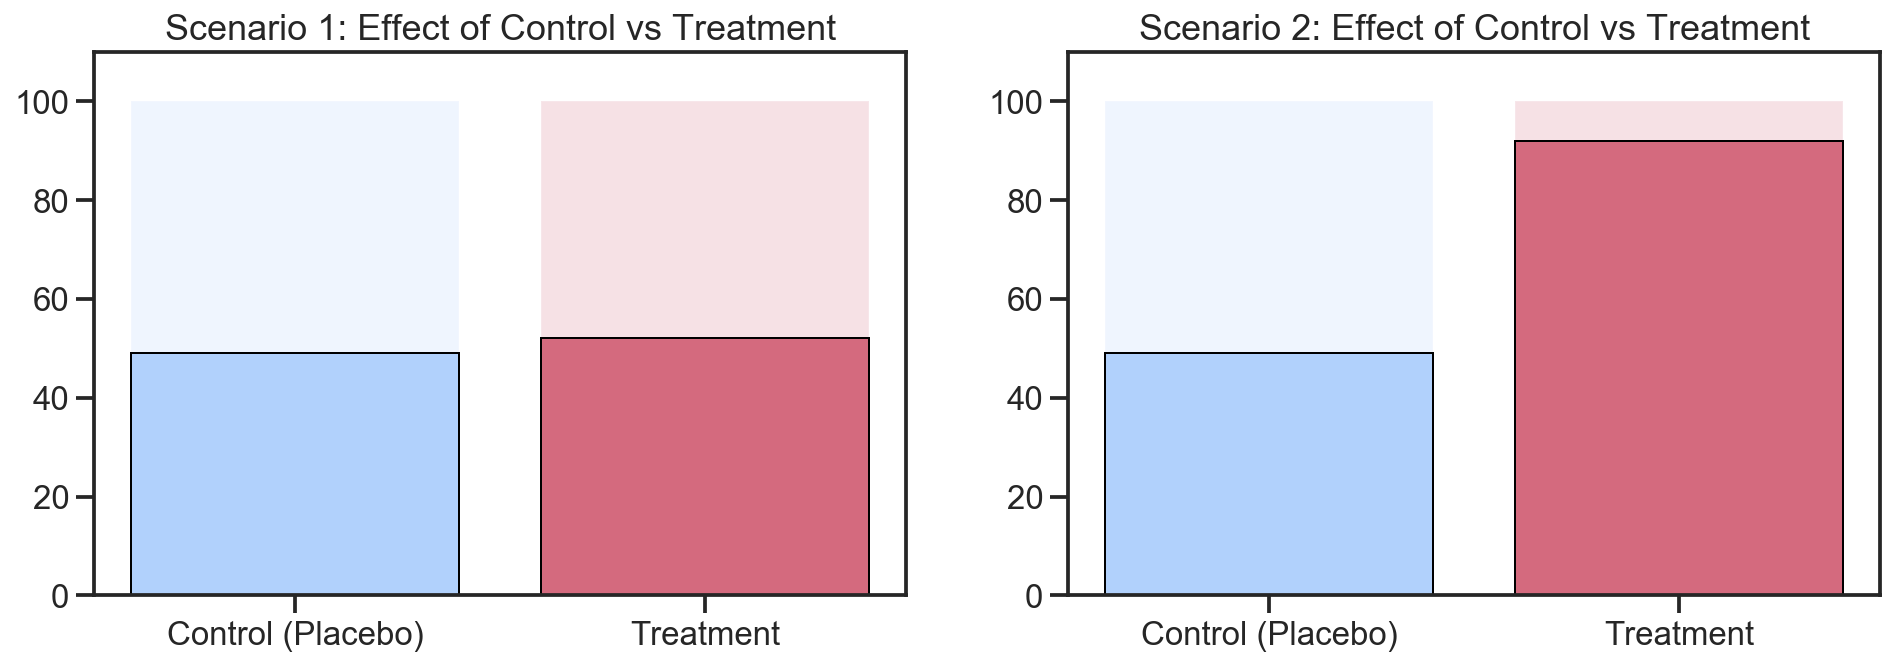

In [47]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[100,100], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    linewidth=1,
    alpha=0.2
)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[49,52], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    edgecolor="black",
    linewidth=1,
)
plt.title("Scenario 1: Effect of Control vs Treatment")
plt.ylim(0,110)

plt.subplot(1, 2, 2)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[100,100], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    linewidth=1,
    alpha=0.2
)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[49,92], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    edgecolor="black",
    linewidth=1,
)
plt.title("Scenario 2: Effect of Control vs Treatment")
plt.ylim(0,110)

plt.show()

Now, suppose instead that 92 out of 100 patients taking the medication showed improvement, compared to only 49 of 100 in the control group (plot on right). It is still possible that the result is unrelated to the drug; the patients in the treatment group may have just been very lucky, and of course the experiment may have missed controlling for a **confounder**. However, that is now a _much less likely explanation_. In the language of statistical inference, the following would most likely be concluded:

1. If the experimental drug has no effect, we would rarely see this amount of variation in outcomes between those who are receiving the drug and those who are receiving the placebo.
2. It is therefore highly improbably that the drug has no positive effect.
3. The alternative, and more likely, explanation for the pattern of data observed is that the experimental drug has a positive effect. 

This is the payoff for all of our work in the introduction to statistics post! The main goal surrounding statistics, and really all of applied mathematics for that matter, is _not_ to just go through an array of calculations just to seem smart-no, it is to gain insight into the world around us! In the case of statistics, it is used to gain insight into social phenomena, to determine confidence around certain measurements and experiments, to ensure that experiments are conducted in a valid manner. To summarize:

> Statistics, and in particular statistical inference, are used in order to gain _insight_ into the world around us. They can take a complex and intractable universe and find underlying trends that humans can understand and use advantageously. 

## 1. Hypothesis testing
As we stated earlier, statistics alone cannot _prove_ anything. What it allows us to do is accept or reject an explanation based on it's relative likelihood of occuring. Put more formally, when performing any statistical inference we start by defining an explicit or implicit **null hypothesis**. This is our starting assumption that will either be accepted or rejected based on our analysis. Along side our null hypothesis is the **alternative hypothesis**, which based on logic is accepted if our null hypothesis is rejected. To make this more concrete, here is an example:

* **Null Hypothesis**: The new drug is no more effective at preventing malaria than a placebo
* **Alternative Hypothesis**: The new drug can help prevent malaria. 

We then would have our actual data (which can be observational, but in scenarios like this it is frequently gathered via a randomized controlled trial. In the case of the RCT, let's say that the group receiving the experimental drug has far fewer cases of malaria than the control group. This would be extremely unlikely if the drug had no medical impact. Hence, we would _reject_ the null hypothesis that the drug is no more effective than a placebo, and hence we accept the alternative hypothesis. 

To be clear, semantics do play a role here. We have not actually _proven_ our alternative hypothesis; in reality we have merely failed to reject our _null hypothesis_. 

Additionally, you may be wondering:

> How do we know if the difference between two quantities is **significant**? 

That is a fantastic question, and will be something to keep in mind throughout all of my posts on statistics, AB testing, and Bayesian Inference. In order to be significant we can say that the difference between two quantities _probably is not due to chance_. 

On the other hand, if we are talking about a difference **not being significant**, then we are saying that there is not enough evidence to say that an observed difference between two quantities is not random. _Or_, we could also be saying that the difference is _smaller than we care about_. 

### 1.1 Hypothesis Testing - High Level Overview
With the above understood, I want to give an overview of hypothesis testing from a different vantage point. I think that it is relatively clear that we are asking the _qualitative_ question: 

> Is this difference real (or just statistical noise)?

However, the goal of hypothesis testing is reframe this into a _quantitative/mathematical_ question:

> What is the **probability** that the difference we are observing is due to chance? 

In order to do this we will perform a **proof by contradiction**: We start by assuming the _null hypothesis_, which states that their is no difference and that what we are seeing is just random, and then we perform a hypothesis test in order to find the _probability of the null hypothesis_. This probability is also known as the **p-value**. The _p-value_ is defined as:

> **p-value**: The probability that the null hypothesis is true. 

In general, we want to arrive at a _p-value_ of less than 0.05, which translates to: there is only a 5% chance that two identical distributions could have produced these results. Now, before we go through a full example of hypothesis testing, we need to go over some background surrounding **parameter estimation** and **confidence intervals**.

## 2. Parameter Estimation 

### 2.1 Parameter Estimation - Bernoulli Distribution
Consider the following situation: you run an e-commerce site, and you want to track and measure the _click-through-rate_ (CTR) for different users. The CTR is a metric that can either be yes or no, meaning the user either entered the website, found an item, went to the checkout and completed the purchase (_buy_), or they did not (_don't buy_). 

This is not a Gaussian Distribution, rather it is more like that of a coin toss, meaning there are two possible outcomes-namely a **bernoulli distribution**:

$$P(n) = p^n (1-p)^{1-n}$$

Where $p$ is the probability of buying something, $p = P(buy)$. Let's say that we have historical data related to five users:

|User|Buy/Not buy|
|----|----|
|1|Buy|
|2|Not Buy|
|3|Not Buy|
|4|Buy|
|5|Not Buy|

If we know that $P(buy) = p$, and there are only two outcomes, then it follows that:

$$P(not \; buy) = 1 - p$$

We also know that these events are **independent** and **idenitically distributed** (IID); in other words, person 1 buying/not buying does not effect the outcome of person 4. Finally, keep in mind that the bernoulli distribution only has one parameter, $p$, while the gaussian distribution has two parameters $\mu$ and $\sigma^2$.

With all of the above information, we want to answer the following question:

> What is the total likelihood of our observations in the above table?

Well, based on the Bernoulli distribution, we can say that the total likelihood is equal to:

$$L(2 \; buy, 3 \; not \;buy) = p^2 (1-p)^3 = P(buy)P(not \; buy)P(not \; buy)P(buy)P(not \; buy)$$

Above, we were able to multiply the probabilities because they were independent events. This can be generalized as:

$$L(N_{buy}, N_{!buy}) = p^{N_{buy}} (1-p)^{N_{!buy}}$$

Keep in mind that we do _not_ know $p$ yet. So, at this point we cannot calculate the total likelihood. In order to do so, we must answer the following question first:

> What is the **maximum likelihood estimate** of $p$, based on the data that we have collected?

For more information on maximum likelihood estimation see my post in the mathematics section, but here is a brief overview: we use maximum likelihood estimation in order to estimate the **parameter** (in this case $p$) that maximize the likelihood of observing the data that we did. 

Visually, if we iterate over all values of $p$ from $[0,1]$, plugging into our bernoulli equation:

$$L(N_{buy} = 2, N_{!buy} = 3) =  p^2 (1-p)^3$$

$$L(data) =  p^2 (1-p)^3$$

We end up with:

In [ ]:
lower_bound = 0
upper_bound = 1
length = 2000

plt.ioff()                          

fig = plt.figure(figsize=(12, 5), dpi=150)       
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_ylabel("Probability", fontsize=20)
ax1.set_title("Bernoulli Distribution: Buy vs. Not Buy", pad="10")

ax2.set_title(r"Total Likelihood of Observations vs. $p$", pad="10")
ax2.set_ylabel("Total Likelihood of Observations", fontsize=20)
ax2.axhline(y=0, color='grey')
ax2.axvline(x=0, color='grey')
ax2.axvline(x=0.4, color=sns.xkcd_rgb["greenish"], linestyle="dashed") # MLE line
ax2.set_xlabel("$p$", fontsize=20)


def mle(p):
    return np.power(p, 2)*np.power(1-p,3)

rects = ax1.bar(
    x=[r"P(Buy) = $p$",r"P(Not Buy) = $1-p$"],
    height=[0,100], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    linewidth=1,
    alpha=0.2,
    edgecolor="black"
)
mle_line = ax1.axhline(y=0.4, color=sns.xkcd_rgb["greenish"], linestyle="dashed") # MLE line

ax_mle, = ax2.plot(0, 0, lw=3, c=sns.xkcd_rgb["red"])                         # Initialize plot object for distance
marker1, = ax2.plot(lower_bound, lower_bound, 'or')

def animate(current_p):
    p = np.linspace(lower_bound, current_p, length)
    rects[0].set_height(current_p)
    rects[1].set_height(1 - current_p)
              
    ax_mle.set_data(p, mle(p))             
    marker1.set_data(current_p, mle(current_p))

    return rects, ax_mle

def init():
    ax1.set_ylim(0, 1) 
    ax2.set_xlim(0, 1)                               # Initialize x and y limits
    ax2.set_ylim(0, 0.05) 
    return ax_mle,

""" Define steps and create animation object """
step = 0.0025
steps = np.arange(lower_bound, upper_bound, step)

plt.tight_layout()

# For rendering html video in cell
# html_video = HTML(
#     animation.FuncAnimation(
#         fig,
#         animate,
#         steps,
#         init_func=init, 
#         interval=25,
#     ).to_html5_video()
# )
# display(html_video)

gif_video = animation.FuncAnimation(
        fig,
        animate,
        steps,
        init_func=init, 
        interval=25,
    )

gif_video.save('mle_estimation.gif', writer='imagemagick')

plt.close()

<img src="https://drive.google.com/uc?id=1r41RLLxYvVbwQpA4j0cENRu0zV7bIaBA" width="800">

From the above visualization it is clear that the value of $p$ which maximize the likelihood of observing the data that we did is $0.4$. This is based on the value where the likelihood plot on the right peaks, namely $p=0.4$. Now, with a little bit of calculus we can solve for this arg max without needing to look a the plot. To do there we want to take the derivative of our likelihood function and set it equal to zero; this way we can find our extrema. 

There is one minor implementation detail I must mention-in order to prevent computational precision issues from arising (these come about due to multiplying together many small probabilities), we will take the $log$ of our likelihood.

$$L(N_{buy}, N_{!buy}) = p^{N_{buy}} (1-p)^{N_{!buy}}$$

$$log \Big\{ L(N_{buy}, N_{!buy}) \Big\} = log \Big\{ p^{N_{buy}} (1-p)^{N_{!buy}}\Big\} = N_{buy} log(p) + N_{!buy} log(1-p)$$

We can then take the derivative and set to 0:

$$\frac{\partial L}{\partial p} = \frac{N_H}{p} - \frac{N_T}{(1-p)} = 0$$

And finally, we can solve for $p$:

$$p = \frac{N_{buy}}{N_{buy} + N_{!buy}}$$

Which, just a quick sanity check we can see that it does indeed result in the value of $p$ that maximizes our total likelihood: 

$$p = \frac{2}{2 + 3} = 0.4$$

And, if we let $Buy = 1$ and $!Buy = 0$ then we can end up with standard formula for the mean:

$$p = \frac{1}{N} \sum_{i=1}^N x_i$$

Now, we have just performed our **parameter estimation** based upon our data, but there is something that may be troubling you. Based on the above methodology, if we had observed 20 people buy and 30 people not buy, we would still end up with a 40% probability $p$ that someone buys. The same can be said if we were to observe 2000 buy and 3000 not buy. 

Yet, intuitively we know that the more observations we have, the more reliable our parameter estimate is, and the less likely it is to be skewed due to random chance. The way that we deal with that in standard **frequentist statistics** is through the use of **confidence intervals**. We will delve into what they are and how they work in the next section, but first I want to go over one more example of parameter estimation concerning the gaussian distribution.

### 2.2 Parameter Estimation - Gaussian Distribution
I would like to pose the following question:

> How do you find the mean of a gaussian distribution?

As we did in the example above, we will again use maximum likelihood estimation. Consider for a moment that we collected one sample from a gaussian distributed data source, which we will call $x$. What is the probability density of that one point? Well, we simply need to plug it into the gaussian distribution formula:

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\big( -\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2}\big)$$

And we will get a single number as a result, the probability density of observing that single sample. Of course in real experiments we will be collecting many samples. Generally, these samples are **IID**, which in this case means:
* **Identically Distributed**: Each sample is generated from a gaussian distribution with the same mean and variance
* **Independent**: The outcome of one sample does not effect the outcome of any other samples. Think of a coin toss. Just because I flip heads on my first try does not mean that I am any more likely to flip heads on the second try. 

This independence also means that if we wanted to know the joint probability of all the sample we have observed, we just multiply the individual probabilities of each sample together:

$$p\big(x_1, x_2,...,x_n\big) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} exp\big( -\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2}\big)$$

Now, the equation above is nearly correct for our purposes, we just need to make one final update. Our goal is to the find the mean, $\mu$, of this gaussian. So, we can define the probability of the data as:

$$p\big(x_1, x_2,...,x_n \mid \mu \big) = \prod_{i=1}^N p\big(x_i \mid \mu \big)$$

**Data Likelihood**<br>
The above probability has a name: the **likelihood distribution**. In general terms, the likelihood distribution represents the probability of the observed data, given the parameters. In our case, this is the probability of our observations, given the mean of the gaussian distribution:

$$p(data \mid parameters)$$

Our parameters will depend entirely on what the model is, e.g. Gaussian, Bernoulli, Beta, Gamma, etc. Now the Gaussian does have two parameters, $\mu$ and $\sigma$, but we will focus on $\mu$. 

**Maximum Likelihood**<br>
Now that we have our likelihood, how do we maximize it? In other words, what is the best value for $\mu$ such that our total likelihood of observing our data is maximized. Visually, we can think of iterting over the different values that our parameter, $\mu$, can take on, and determing how likely our data would be in each case. This can be seen below:

In [68]:
def mle_gaussian(x, mu, sigma):
    likelihood_of_data = norm.pdf(x, mu, sigma)
    log_likelihood_of_data = np.log(likelihood_of_data)
    return np.sum(log_likelihood_of_data)

In [69]:
lower_bound = -5
upper_bound = 5
length = 2000

plt.ioff()                          

fig = plt.figure(figsize=(12, 5), dpi=150)       
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax2.set_title(r"Total Likelihood of Observations vs. $\mu$", pad="10")
ax2.set_xlabel(r"$\mu$", fontsize=20)

means = np.linspace(lower_bound, upper_bound, length)
sigma = 1
expected_mean = 1
num_observed_points = 30
observed_data = np.random.normal(expected_mean, sigma, num_observed_points)
x_axis = np.arange(-5, 5, 0.001)

ax2.axvline(x=expected_mean, color=sns.xkcd_rgb["greenish"], linestyle="dashed")

ax_mle, = ax2.plot(0, 0, lw=3, c=sns.xkcd_rgb["red"])                         # Initialize plot object for distance
marker1, = ax2.plot(lower_bound, 0, 'or')
mu = np.array([])
likelihoods = np.array([])

def animate(current_mu):
    # Gaussian Plot - left 
    ax1.clear()
    gaussian_dist = norm.pdf(x_axis, current_mu, sigma)
    ax1.plot(x_axis, gaussian_dist, c=sns.xkcd_rgb["grey"],linewidth=1)
    ax1.fill_between(x_axis, gaussian_dist, color=sns.xkcd_rgb["powder blue"], alpha=0.5)
    ax1.scatter(observed_data, np.zeros(len(observed_data)), c=sns.xkcd_rgb["neon purple"], alpha=0.7, zorder=4)

    ax1.axvline(x=current_mu, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
    ax1.axvline(x=expected_mean, color=sns.xkcd_rgb["greenish"], linestyle="dashed")
    ax1.annotate(r"$\mu$ = {}".format(round(current_mu, 2)), [-4.5,0.38], size=18)
    ax1.set_title(r"Gaussian Distribution: Function of $\mu$", pad="10")
    ax1.set_xlabel(r"$x$", fontsize=20)

    # MLE Update - right
    global mu
    global likelihoods
    current_mu_likelihood = mle_gaussian(observed_data, current_mu, sigma)
    mu = np.append(mu, current_mu)
    likelihoods = np.append(likelihoods, current_mu_likelihood)
    ax_mle.set_data(mu, likelihoods)     
    marker1.set_data(current_mu, mle_gaussian(observed_data, current_mu, sigma))

    return ax_gaussian, ax_mle

def init():
    ax1.set_ylim(0, 1) 
    ax2.set_xlim(-5, 5)                               # Initialize x and y limits
    ax2.set_ylim(-650, 0) 
    return ax_gaussian, ax_mle

""" Define steps and create animation object """
step = 0.01
steps = np.arange(lower_bound, upper_bound, step)

plt.tight_layout()

# For rendering html video in cell
# html_video = HTML(
#     animation.FuncAnimation(
#         fig,
#         animate,
#         steps,
#         init_func=init, 
#         interval=25,
#     ).to_html5_video()
# )
# display(html_video)
gif_video = animation.FuncAnimation(
        fig,
        animate,
        steps,
        init_func=init, 
        interval=25,
    )
gif_video.save('mle_gaussian_estimation.gif', writer='imagemagick')

plt.close()

<img src="https://drive.google.com/uc?id=1cyHP0ZF8-tt6Ng4qrZSX5iA_yhd03MRa" width="800">

Above, I have created two plots with the following features:
* On the left I have plotted some data, $x$, in purple. This data was sampled from a normal distribution whose mean is known to be one: $\mu = 1$. 
* Then, in that same plot, I create a new gaussian distribution for each value of $\mu$. The mean of the gaussian/current value of $\mu$ is shown by the blue dotted line. 
* On the left, the green dotted line represents that value of $\mu$ that will maximize the likelihood that we observe our data, $x$. 
* On the right, I am plotting the total log likelihood of observing our observations, for a given $\mu$. 
* In other words, on the right I am plotting $p\big(x_1, x_2,...,x_n \mid \mu =i \big)$ for $i = [-5,5]$

As with the bernoulli distribution, we could easily use the right plot in order to see that $\mu$ is maximized where there is a peak. Once again, we can use calculus in order to solve this mathematically. As with before, we will want to take the derivative and set it equal to zero. As I mentioned, we will be taking the log of the likelihood before we take the derivative; this is because the derivative of an exponential is just itself, which will make things more difficult to solve.

$$L = log \Big( p(X \mid \mu) \Big) = log \Big( \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} exp\big( -\frac{1}{2} \frac{(x_i -\mu)^2}{\sigma^2}\big) \Big)$$

$$L = \sum_{i=1}^N log \Big ( \frac{1}{\sqrt{2 \pi \sigma^2}} exp\big( -\frac{1}{2} \frac{(x_i -\mu)^2}{\sigma^2}\big) \Big)$$

$$L = \sum_{i=1}^N \Big(\frac{ -(x_i -\mu)^2}{2\sigma^2} \Big) + \text{constant wrt } \mu$$

We can now take the derivative of our likelihood function:

$$\frac{\partial L}{\partial \mu} = \sum_{i=1}^N \frac{x_i - \mu}{\sigma^2} = 0$$

$$\mu = \frac{1}{N} \sum_{i=1}^N x_i$$

And we arrive at a familiar expression: the sample mean of a random variable! 

As with the bernoulli case, I pose the following question:

> How can we differentiate between a $\mu$ that was determined from 50 data points vs 5000 data points?

We will look at the answer in the next section.

Before moving on, there is something important to note regarding parameter estimation. In each of the two cases we have gone through, had data and tried to fit a distribution to the data. In the first case we _chose_ to fit a bernoulli distribution, and in the second case we _chose_ to fit a gaussian distribution. This was our _choice_. We could have fit another distribution to them and estimated that _respective distribution's parameters_. This idea of selecting different distributions and fitting them to the data based on different parameters must be kept in mind.

## 3. Confidence Intervals
Now that we have gone through two examples of estimating a parameter of a distribtion, we can look at how **frequentist statistics** deals with the uncertainty of measurement of parameters: **confidence intervals**. Why do we care about the uncertainty of the estimates, you may ask? Well think about the following: Say you are advising an executive at your company about a decision involving which landing page to use in order to maximize customer conversions. If you are referrencing metrics that you have estimated from historical data, wouldn't you like to be able to have a mathematical way of expressing the uncertainty surrounding those metrics? 

That is the whole idea behind confidence intervals. They places us in a stronger position to convey information about analysis that we have performed, estimates we arrived at, and so on. Without them, it is impossible to differentiate a conclusion reached off of 5 historical observations and 5,000. 

So, with that said, we can begin. To start, let's look at the **sum of random variables**.

### 3.1 Sum of Random Variables
To begin, we need to think about what the sum of random variables represents. Well, let's say we have two random variables, $X$ and $Y$. We then have $Z$ equal to their sum:

$$Z = X + Y$$

Is $Z$ also random? Yes it is! This means that it also has a probability distribution, a mean, variance, etc. Well, this is very helpful in our situation of parameter estimation! Let us say that our parameter estimate of the mean is $\hat{\mu}$, and the true parameter is $\mu$. We can see that the estimate mean is the sum of random variables:

$$\hat{\mu} = \frac{1}{N} \sum_{i=1}^N x_i$$

So, putting together everything that we have been talking about up until this point:

> The central limit theorem states that the sum of independent and identically distributed variables tends to a Gaussian Distribution.

This means that out parameter estimate, $\hat{\mu}$, will tend to a gaussian distribution!

$$\hat{\mu} \approx N(\mu, \frac{\sigma^2}{N} )$$

Specifically, the central limit theorem states that $\hat{\mu}$ is gaussian distributed with mean $\mu$ and variance $\frac{\sigma^2}{N}$, where this variance is the standard error squared (recall, standard error is the standard deviation of the sample means). 

<img src="https://drive.google.com/uc?id=1qdxnH78cQrDDT4iVXCsf3zfSEzSVZtvd">

Now, we see that the variance of this gaussian is going to be $\frac{\sigma^2}{N}$. This makes intuitive sense, because as you collect more samples, the variance of your estimates should decrease. I highly encourage you take a look at the my introduction to statistics post, specifically the section pertaining to the central limit theorem to get a clear visualization of this. 

In english, what we are saying is say I collect 5 samples from a distribution for $\mu$, and calculate this sample mean. I repeat this 100 times. Because I only collected 5 samples, they may just happen to all be far from each other. This means they are spread out, and have a higher variance. If I repeated this process, but each iteration I collected 200 samples, based on the probability distribution of $\mu$, the sample means are going to be closer to the true mean, and the variance will have decreased.

At this point it is worth noting what $\mu$ and $\sigma$ are-they actually refer to the mean and variance of $X$:

$$E(X) = \mu$$

$$var(X) = \sigma^2$$

So $\mu$ is the true mean of $X$, and it is also the true mean of $\hat{\mu}$. Likewise, $\sigma^2$ is the variance of $X$, while $\frac{\sigma^2}{N}$ is the variance of $\hat{\mu}$. This means that if the variance of $X$ is large, then we will need many more samples to get an accurate $\hat{\mu}$. The central limit theorem shows that as $N$ approaches $\infty$, $\hat{\mu}$ will approach $\mu$. 

Note the difference in scale between the numerator and the denominator in the variance; the numerator grows as a quadratic in $\sigma$, but the denominator grows linearly in $N$:

$$var(\hat{\mu}) \propto \sigma^2$$

$$var(\hat{\mu}) \propto \frac{1}{N}$$

Hence, we know the following:

> You need many more samples to decrease the variance of $\hat{\mu}$, but just a small increase in $\sigma$ can lead to a large increase in the variance of $\hat{\mu}$.

Mathematically we can write the above as:

$$\hat{\mu} - \mu \approx N(0, \frac{\sigma^2}{N})$$

### 3.2 Confidence Intervals
Let's state our goal at this point:

> We want to know the range of values that are likely to contain the true $\mu$.

Visually, we can do by shading in the middle 95% of the gaussian. This allows to (almost) say that "$\mu$ is probably here":

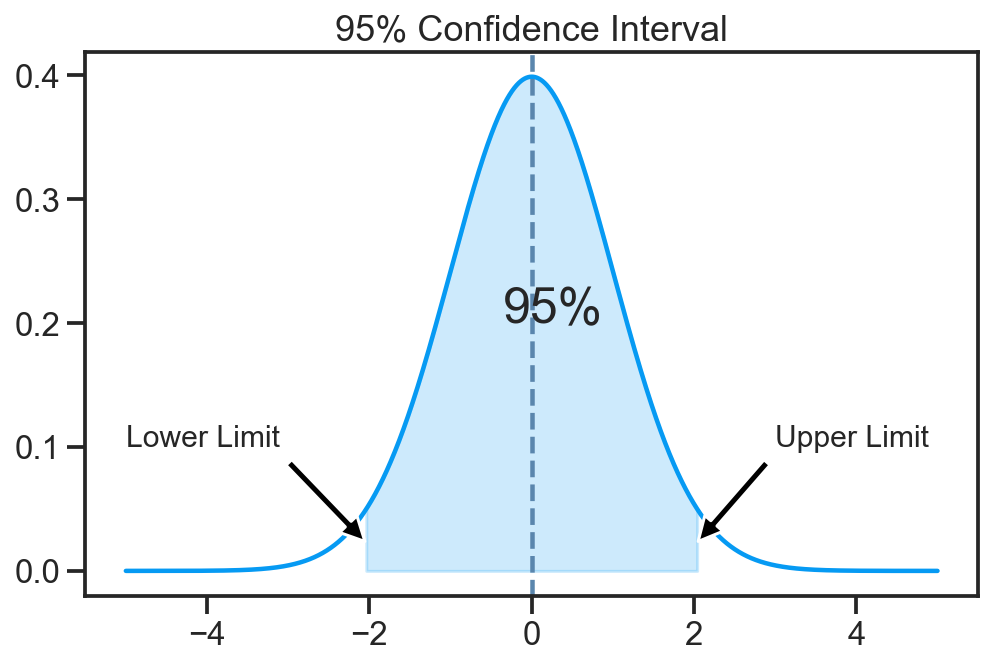

In [48]:
fig = plt.figure(figsize=(8, 5))   

lower_bound = -2.5
upper_bound = 2.5
length = 2000

mu = 0
sigma = 1
expected_mean = 1
num_observed_points = 50
observed_data = np.random.normal(expected_mean, sigma, num_observed_points)

x_axis = np.arange(-5, 5, 0.001)
y = norm.pdf(x_axis, mu, sigma)
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.axvline(x=0, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")

plt.annotate(
    'Lower Limit',
    xy=(-2, 0.02),
    xytext=(-5, 0.1),
    arrowprops=dict(facecolor='black', shrink=0.05),
    size=15
)

plt.annotate(
    'Upper Limit',
    xy=(2, 0.02),
    xytext=(3, 0.1),
    arrowprops=dict(facecolor='black', shrink=0.05),
    size=15
)

plt.annotate(
    '95%',
    [-0.35, 0.2],
    size=25
)

plt.title("95% Confidence Interval")

plt.fill_between(x_axis, y, where=(y > 0.05), color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.show()

The more samples we have, the narrower our probability distribution is for $\hat{\mu}$, meaning that our confidence interval will be narrow! The opposite is true for a small number of samples. Note, a 95% confidence interval does **not** tell us "$\mu$ is in this interval with probability 95%". In reality, all we can say is: if we did many experiments to calculate the sample mean, 95% of the time, the confidence interval would contain the true $\mu$. 

#### Confidence Level/Significance Level
We have a symbole that we use to represent this confidence level:

$$1 - \alpha$$

Where we call the significance level $\alpha$. 

#### Confidence Interval Limits
Now, how do we go about finding the actual confidence interval? In other words, we want the min and max value for the range where $\mu$ should lie; we can call them $x_{left}$ and $x_{right}$. We want to find the limits such that the area under the Gaussian is 0.95. Again, calculus provides the tools for us-we can use an integral!

$$0.95 = 1 - \alpha = \int_{x_{left}} ^{x_{right}} N \big( x \mid 0, \frac{\sigma^2}{N}\big) dx$$

The above integral cannot be solved by hand, so we will not even try. Rather, we will manipulate it into a form such that we can find the answer computationally. First off, since this is a gaussian with an arbitrary variance, the first thing that we can do is convert it to a **standard normal**, which looks like this:

<img src="https://drive.google.com/uc?id=1ej2rCqpKqnlSSw9lrwtKRMJ4jJBcAuag">

Mathematically this is done by taking $X$ and subtracting the mean, and then dividing by the standard deviation:

$$Z = \frac{X - \mu_x}{\frac{\sigma_x}{\sqrt{N}}}$$

Where $Z$ is now our normalized $X$. We can update our prior equation to be:

$$0.95 = 1 - \alpha = \int_{z_{left}} ^{z_{right}} N \big( z \mid 0, 1\big) dz$$

Now, you may recall the definition of the **cumulative distribution function** (CDF):

$$P(X \leq x) = \int_{-\infty}^{x} p(x) dx$$

Well, we are currently dealing with the integral of the gaussian PDF, and we know that the CDF is equal to some integral of the PDF. So, we can absolutely make use of it! In particular, the CDF is the integral from $-\infty$ to $x$ over the PDF. Keep in mind that that gaussian distribution is symmetric; in other words the left side is a mirror image of the right side. Hence, if we want 5% of the weight to be on the tail end, then we want each tail to carry 2.5% of the weight.

This means that the integral from $-\infty$ to $z_{right}$ should give us an area of $0.975$:

$$0.975 = \int_{z_{left}} ^{z_{right}} N \big( z \mid 0, 1\big) dz = \Phi(z_{right})$$

Typically, we give the above function the name $\Phi$. What we are actually looking for is the inverse of this function, namely:

$$z_{right} = \Phi^{-1} (0.975)$$

Now, as I said earlier, this integral is not possible/realistic for us to solve by hand. Thankfully however, `scipy` has a function that will allow us to solve it without a problem. It can be found via:

```
scipy.stats.norm.ppf
```

The `ppf` stands for percent point function, which really just stands for _inverse of the CDF_. You may be wondering what the left side is equal to; well, because the gaussian is symmetric:

$$z_{left} = - z_{right}$$

Or, we could easily just use the inverse CDF function again:

$$z_{left} = \Phi^{-1} (0.025)$$

Visually, $z_{left}$ and $z_{right}$ can be seen below, where the each shaded red area is equivalent to 2.5%. 

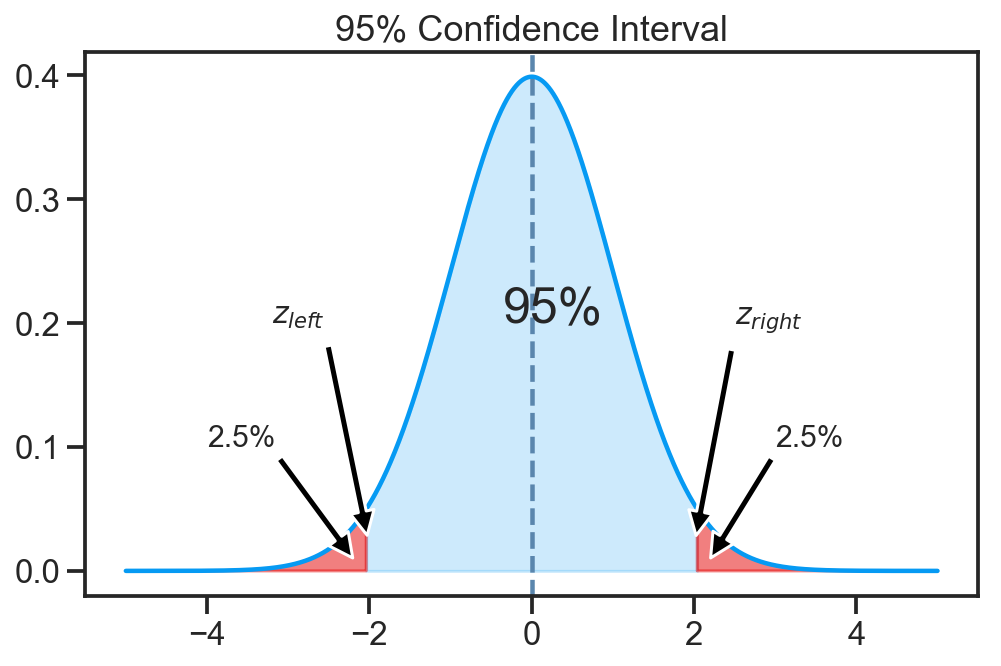

In [22]:
fig = plt.figure(figsize=(8, 5))   

lower_bound = -2.5
upper_bound = 2.5
length = 2000

mu = 0
sigma = 1
expected_mean = 1
num_observed_points = 50
observed_data = np.random.normal(expected_mean, sigma, num_observed_points)

x_axis = np.arange(-5, 5, 0.001)
y = norm.pdf(x_axis, mu, sigma)
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.axvline(x=0, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")

plt.annotate(
    r'$z_{left}$',
    xy=(-2, 0.02),
    xytext=(-3.2, 0.2),
    arrowprops=dict(facecolor='black', shrink=0.05),
    size=15
)

plt.annotate(
    r'$z_{right}$',
    xy=(2, 0.02),
    xytext=(2.5, 0.2),
    arrowprops=dict(facecolor='black', shrink=0.05),
    size=15
)

plt.annotate(
    "2.5%",
    xy=(2.2, 0.01),
    xytext=(3, 0.1),
    arrowprops=dict(facecolor='black', shrink=0.005),
    size=15
)

plt.annotate(
    "2.5%",
    xy=(-2.2, 0.01),
    xytext=(-4, 0.1),
    arrowprops=dict(facecolor='black', shrink=0.005),
    size=15
)

plt.annotate(
    '95%',
    [-0.35, 0.2],
    size=25
)

plt.title("95% Confidence Interval")

plt.fill_between(x_axis, y, where=(y > 0.05), color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.fill_between(x_axis, y, where=(y < 0.05), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.show()

Because these are very standard, many statistics text books will just use rounded off numbers. After solving for $z_{left}$ and $z_{right}$ (via scipy) we would end up with:

$$z_{left} = -1.96$$

$$z_{right} = 1.96$$

Another way that you may see these values denoted is:

$$z_{left} = z_{\frac{\alpha}{2}}$$

$$z_{right} = z_{1 - \frac{\alpha}{2}}$$

Finally, we arrive at our confidence interval! After we have measured $\mu$, we are 95% certain that $\mu$ lies in this range:

#####  <span style="color:#0000cc">$$\text{Gaussian Confidence Interval} \rightarrow \Big[ \hat{\mu} + z_{left}\frac{\sigma}{\sqrt{N}}, \; \hat{\mu} + z_{right}\frac{\sigma}{\sqrt{N}}  \Big]$$</span>

Where above we have denormalized our distribution by adding $\hat{\mu}$ back and multiplying by $\frac{\sigma_x}{\sqrt{N}}$. This is just used to transform from $Z$ to $X$

$$X = Z * \frac{\sigma_x}{\sqrt{N}} + \mu_x$$

However, we do have one problem still! In our confidence interval above, we don't actually know the standard deviation of $X$, $\sigma$! If we don't know the true population mean, $\mu$, we most likely don't know the population standard deviation either. 

Luckily, when finding the confidence interval in the case where we don't know the real $\sigma$, we can use the estimated $\hat{\sigma}$ instead as a valid approximation:

$$\hat{\sigma} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \hat{\mu})^2}$$

I should note that in order to find the non-approximated version of the confidence interval, we would need to use the inverse CDF of the t-distribution instead; this will be saved for a later post. 

Also, something to keep in mind is that we can apply this confidence interval to Bernoulli as well! We simply replace the gaussian symbols with the symbols corresponding to Bernoulli. For Bernoulli, the variance is:

$$var(X) = p(1-p)$$

#####  <span style="color:#0000cc">$$\text{Bernoulli Confidence Interval} \rightarrow \Big[ \hat{p} + z_{left} \sqrt{\frac{\hat{p}(1-\hat{p})}{N}}, \; \hat{p} + z_{right}\sqrt{\frac{\hat{p}(1-\hat{p})}{N}}  \Big]$$</span>

#### Confidence Interval Summary
Let's take a moment to recap everything we just went over, because it is very easy to get lost in the details and miss the big picture.

<img src="https://drive.google.com/uc?id=132w72e6G5EPaX4aAhc48T4aat9fPbP77" width="800">

1. We began by applying the central limit theorem to show that the maximum likelihood estimate of $\mu$ is Gaussian Distributed.
2. We then scaled $X$ to be the standard normal, with a mean $\mu = 0$ and variance $\sigma = 1$.
3. At this point we found the left and right limits that capture 95% of the probability for where $\mu$ could be. Finding these limits allows us to have confidence about that range of values that the true $\mu$ should be observed.
4. Because we scaled $X$, we then need to scale it back.



#### Confidence Interval: Key Point
Now, as we move into hypothesis testing-namely A/B testing-it is very important to keep in mind the following:

> The standard deviation of our estimate $\hat{\mu}$ scales proportionally to the standard deviation of $X$, but inversely proportional to $\sqrt{N}$. This means that we need to collect many more samples in order to make the confidence interval smaller, compared to the standard deviation of the data. 

This is something worth considering, especially if you have any interest in reading my posts concering **bayesian A/B testing**. 

## 4. Hypothesis Testing: Explained via A/B Testing
After several posts pertaining to statistics, and several others to probability, we are finally reaching the full payoff: **hypothesis testing**. I want to explain hypothesis testing in relation to **A/B testing**. So, here is the scenario:

* You are running a software-as-a-service (SAAS) startup.
* You have a landing page where you try and get people to signup.
* A `signup` action is equal to a person entering there email address and clicking the signup button.
* Of course, not everyone who visits your site is going to sign up.
* The `conversion rate` is equal to the proportion of people who sign up.

Now, let's suppose that your lead marketer has identified problems with your landing page. They set out and create a new, supposedly _better_ landing page. As a data scientist, you want to measure which page is better _quantitatively_, through the use of data and mathematics. 

At this point you may be recalling the concept of confidence intervals. Why did we go over them again? Because we knew intuitively that $\frac{1}{10}$ is not as accurate as $\frac{10}{100}$, which is not as accurate as $\frac{100}{1000}$ (even though each fraction yields the same conversion rate). Because of this concept, if page 1 gets $\frac{1}{10}$ clicks, and page 2 gets $\frac{2}{10}$ clicks, we cannot necessarily say that page 2 is worse. However, if page 1 gets $\frac{10}{100}$ clicks and page 2 gets $\frac{20}{100}$ clicks, we are now more certain that page 2 is superior. The question that remains is:

> How can we quantify whether page 2 is superior than page 1?

And the answer (in frequentist statistics) is the perform a traditional statistical test. So, let's set up a simple example to get familiar with the necessary terminology.

### 4.1 Basic example: Are men taller than women?
Suppose that we are measuring the heights of men and women, and we would like to know the answer to the informal question: "Are men taller than women?". The statistical terminology would have us reword that question to be:

> Is the difference in height between men and women statistically significant?

Ah! There is that term **significance** again, which we saw earlier when dealing with confidence intervals. Recall, we used $\alpha$ to represent it, and let it be 5%. We will let it remain at 5%, since that is a standard significance that researchers use (although 1% is also common). You may think to yourself that this is rather strange; we, the researchers, set our own significance level. And not just that, but it is rather arbitrary! You are correct in this line of thinking, and while statistical tests are very powerful, I encourage you to keep these reservations in mind as we move forward. Once we discuss alternative methods, they may seem even more necessary. 

Now, based on the signficance level we just mentioned, we can actually reframe our question: 

> Is the difference in mean height between men and women statistically significant, at the significance level $\alpha$?

#### Types of Hypothesis
In statistical testing, we have two types of hypotheses:

**Null Hypothesis**:<br>
This is where there is _no difference_ between the two groups being compared. For example, we may find that there is no significant difference in the mean height between men and women. Or we may find that there is no difference in effect between drug and placebo. Mathematically we are saying:

$$H_0 : \mu_1 = \mu_2$$

And visually this looks like:

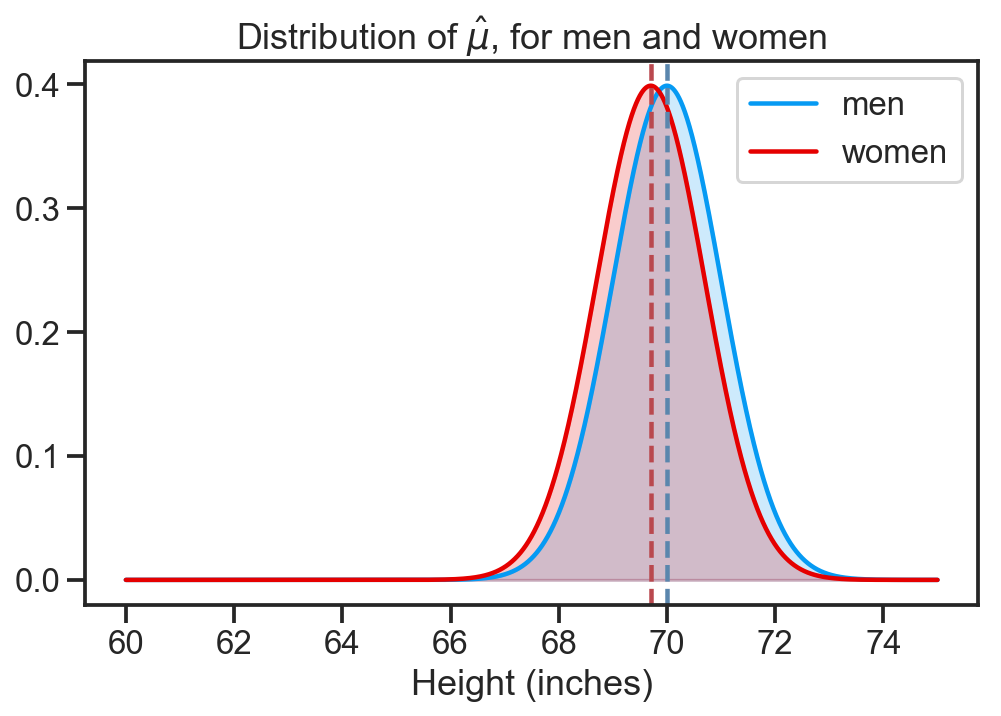

In [54]:
fig = plt.figure(figsize=(8, 5))   

lower_bound = 60
upper_bound = 75
length = 10000

mu_men = 70
mu_women = 69.7
sigma = 1

x_axis = np.arange(lower_bound, upper_bound, 0.001)

y_men = norm.pdf(x_axis, mu_men, sigma)
y_women = norm.pdf(x_axis, mu_women, sigma)

plt.plot(x_axis, y_men, color=sns.xkcd_rgb["azure"])
plt.plot(x_axis, y_women, color=sns.xkcd_rgb["red"])
plt.axvline(x=mu_men, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
plt.axvline(x=mu_women, color=sns.xkcd_rgb["dusty red"], linestyle="dashed")


plt.xlabel("Height (inches)")
plt.legend(['men', 'women'])
plt.title(r"Distribution of $\hat{\mu}$, for men and women")

plt.fill_between(x_axis, y_men, color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.fill_between(x_axis, y_women, color=sns.xkcd_rgb["red"], alpha=0.2)

plt.show()

**Alternative Hypothesis (one sided test)**:
Another type of hypothesis is a one sided alternative hypothesis. This is where state the mean height of men is greater than the mean height of women:

$$H_1 : \mu_1 > \mu_2$$

Visually, this is can be seen below. The mean estimate height for men is clearly greater than for that of women:

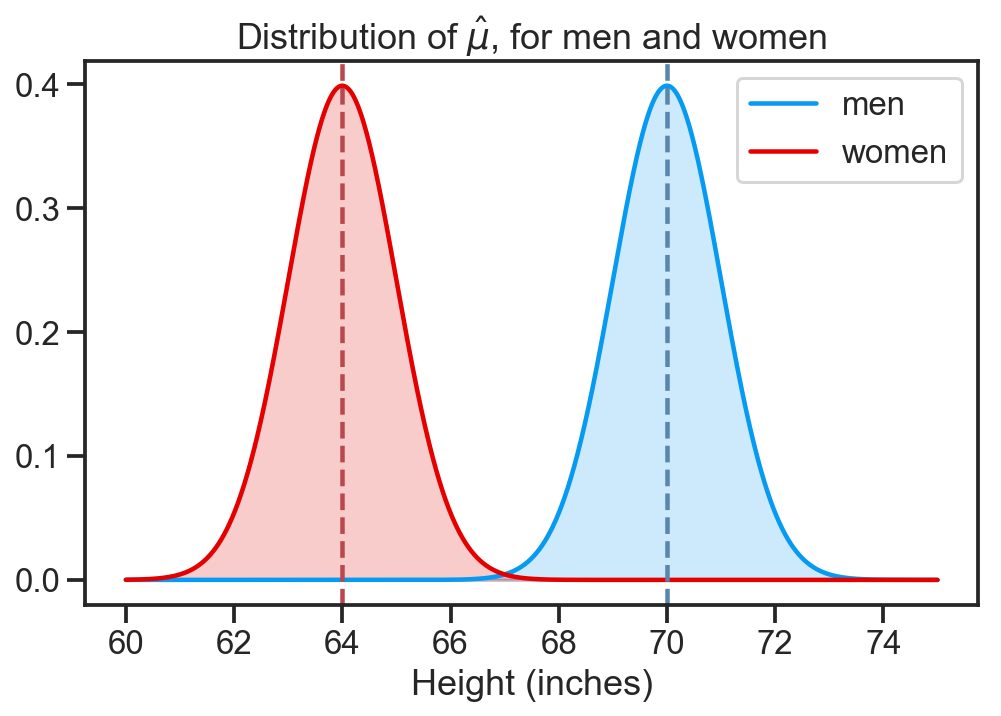

In [56]:
fig = plt.figure(figsize=(8, 5))   

lower_bound = 60
upper_bound = 75
length = 10000

mu_men = 70
mu_women = 64
sigma = 1

x_axis = np.arange(lower_bound, upper_bound, 0.001)

y_men = norm.pdf(x_axis, mu_men, sigma)
y_women = norm.pdf(x_axis, mu_women, sigma)

plt.plot(x_axis, y_men, color=sns.xkcd_rgb["azure"])
plt.plot(x_axis, y_women, color=sns.xkcd_rgb["red"])
plt.axvline(x=mu_men, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
plt.axvline(x=mu_women, color=sns.xkcd_rgb["dusty red"], linestyle="dashed")


plt.xlabel("Height (inches)")
plt.legend(['men', 'women'])
plt.title(r"Distribution of $\hat{\mu}$, for men and women")

plt.fill_between(x_axis, y_men, color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.fill_between(x_axis, y_women, color=sns.xkcd_rgb["red"], alpha=0.2)

plt.show()



**Alternative Hypothesis (two sided test)**:
Finaly, we have a two sided alternative hypothesis. This is where state the mean height of men is simply _not equal to_ than the mean height of women:

$$H_1 : \mu_1 \neq \mu_2$$

And again, visually this can be seen below. On the left the mean estimate of men's heights is greater than that of women, and vice versa on the right. The key is that they are not equal:

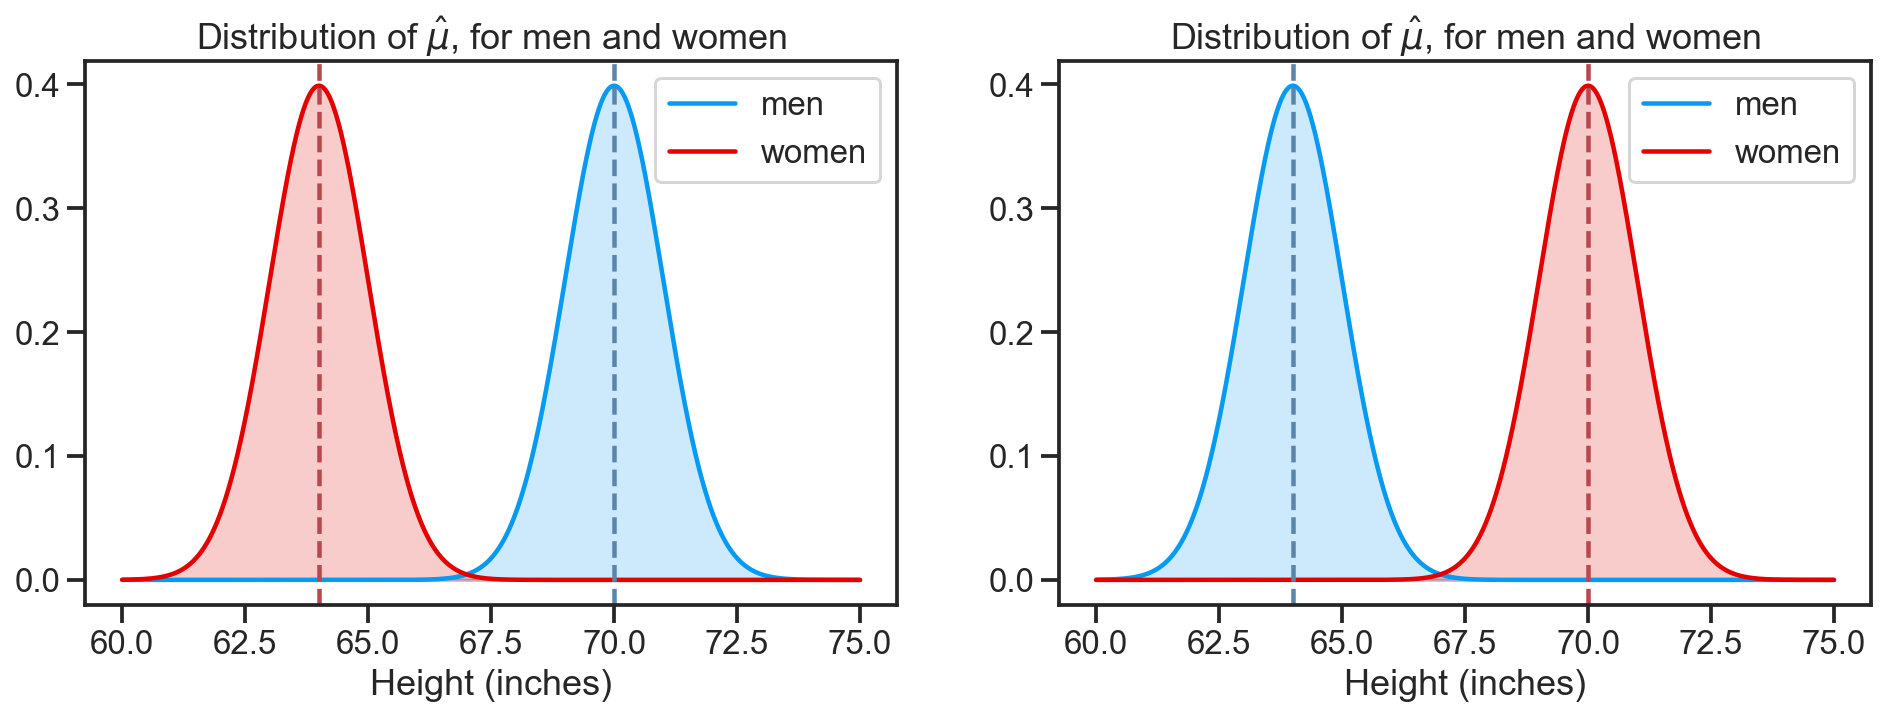

In [57]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(1, 2, 1)

lower_bound = 60
upper_bound = 75
length = 10000

mu_men = 70
mu_women = 64
sigma = 1

x_axis = np.arange(lower_bound, upper_bound, 0.001)

y_men = norm.pdf(x_axis, mu_men, sigma)
y_women = norm.pdf(x_axis, mu_women, sigma)

plt.plot(x_axis, y_men, color=sns.xkcd_rgb["azure"])
plt.plot(x_axis, y_women, color=sns.xkcd_rgb["red"])
plt.axvline(x=mu_men, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
plt.axvline(x=mu_women, color=sns.xkcd_rgb["dusty red"], linestyle="dashed")


plt.xlabel("Height (inches)")
plt.legend(['men', 'women'])
plt.title(r"Distribution of $\hat{\mu}$, for men and women")

plt.fill_between(x_axis, y_men, color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.fill_between(x_axis, y_women, color=sns.xkcd_rgb["red"], alpha=0.2)

plt.subplot(1, 2, 2)

mu_men = 64
mu_women = 70
sigma = 1

x_axis = np.arange(lower_bound, upper_bound, 0.001)

y_men = norm.pdf(x_axis, mu_men, sigma)
y_women = norm.pdf(x_axis, mu_women, sigma)

plt.plot(x_axis, y_men, color=sns.xkcd_rgb["azure"])
plt.plot(x_axis, y_women, color=sns.xkcd_rgb["red"])
plt.axvline(x=mu_men, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
plt.axvline(x=mu_women, color=sns.xkcd_rgb["dusty red"], linestyle="dashed")


plt.xlabel("Height (inches)")
plt.legend(['men', 'women'])
plt.title(r"Distribution of $\hat{\mu}$, for men and women")

plt.fill_between(x_axis, y_men, color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.fill_between(x_axis, y_women, color=sns.xkcd_rgb["red"], alpha=0.2)

plt.show()

### Step 1: Select a Distribution
Now, we will be making an assumption, namely that our data is Gaussian Distributed. This is very common, especially when dealing with human related metrics, such as height and weight. So, both the height of men and the height of women are assumed to be generated from a gaussian process, and the that process may have different means. 

### Step 2: Collect Data
So, we begin by collecting some data; namely, we measure a randomly selected sample of men and women (this random selection is crucial-imagine if to gather our sample we went to the nearest basketball court. Our sample would clearly not be representative of the population as a whole. From each sample, we gather a list of heights:

$$X_1 = \{ x_{11}, x_{12}, ..., x_{1N}\}$$

$$X_2 = \{ x_{21}, x_{22}, ..., x_{2N}\}$$

Where the $X_1$ represents men, and $X_2$ women. 

### Step 3: Define a Test Statistic
Next, we create what is know as a **test statistic**, which we can call $t$. A test statistic is a standardized value that is calculated from sample data during a hypothesis test. By definition, the function that defines your test statistic compares your data to what is expected under the _null hypothesis_. 

The goal of the test statistic is to boil down all of the sample data to one value, the $t$-statistic. The calculation to arrive at the $t$-statistic compares the data be tested (sample means in our case) to the null hypothesis, being sure to incorporate both sample size and variability of the data. Now with that said, we will define $t$ as:

$$t = \frac{\bar{X_1} - \bar{X_2}}{s_p \sqrt{\frac{2}{N}}}$$

Where $s_p$ is known as the **pooled standard deviation**, representing the average of the two standard deviations:

$$s_p = \sqrt{\frac{s_1^2 + s_2^2}{2}}$$

Note that the standard deviations are the unbiased estimates, so we divide by $N-1$ for all $s$, not $N$. Remember, $N$ is the number of samples collected for one group, so if we had 10 men and 10 women then $N$ would be 10. 

It is clear from the formula above that if $\bar{X_1} = \bar{X_2}$, _the condition of our null hypothesis_, then $t$ will be zero. So, we can say that $t$ is a function based on the null hypothesis being true. Realize that $t$ that this is the case specifically due to how we defined the function for $t$; namely, having chosing to use the difference of means. 

#### _t_-distribution
Recall that when we looked into the estimate of the mean, we saw that because it was the sum of random variables, it was therefore also a random variable. Looking at the test statistic, $t$, it is also a function of random variables, (the two respective sample means) and hence a random variable. Now, when performing a hypothesis test we only calculate a single $t$-statistic, but if we were to draw multiple random samples of the same size from the population, and perform the same test, we would obtain many t-statistics and we could plot the distribution of them all. As an aside, this type of distribution is known as a **sampling distribution**. In this case, the sampling distribution has a name, the **t-distribution**. 

What is great about the t-distribution is that it's properties are well known, so we do not need to collect many samples-just the one! A t-distribution can be entirely defined based on it's **degrees of freedom**, $v$, a value directly related to sample size. Note that $v$ generally equals $N-1$. 

Now, visually it looks a lot like the gaussian, but it has fatter tails (more probability on the tail ends):

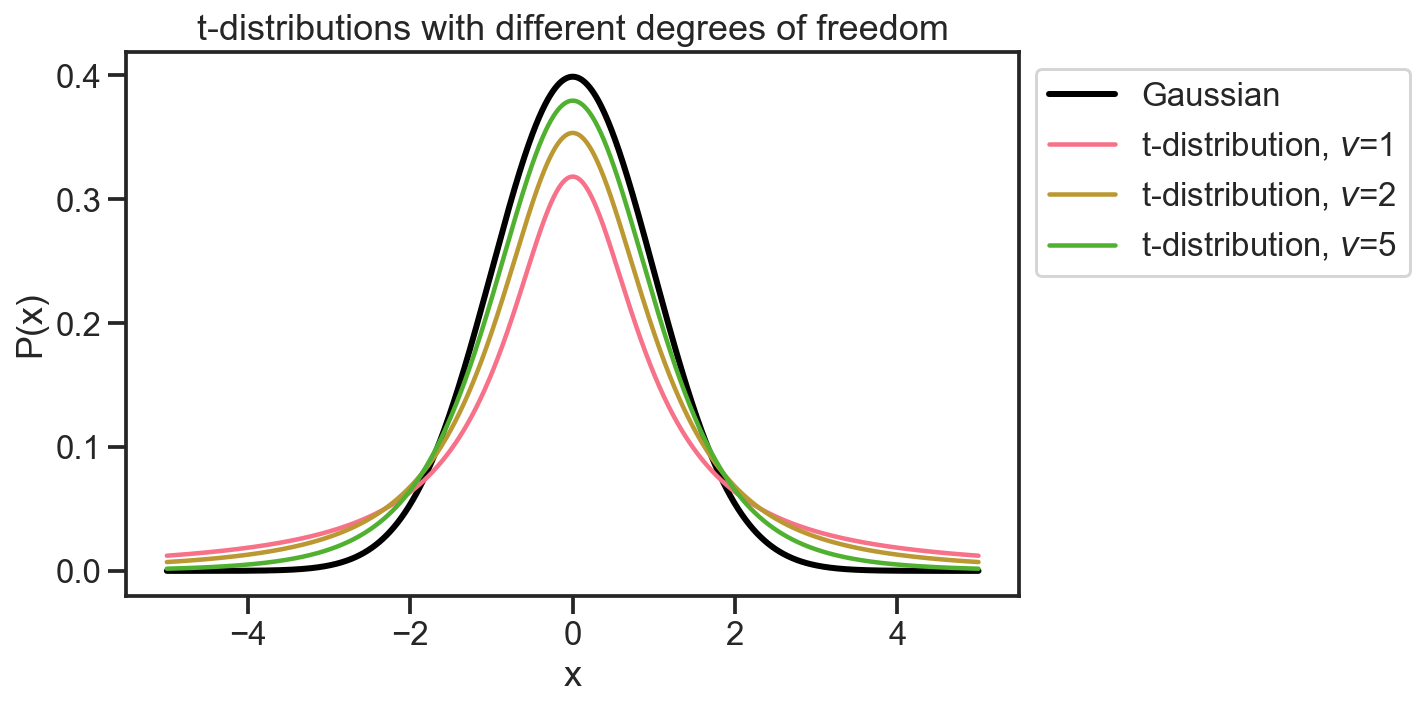

In [27]:
fig = plt.figure(figsize=(8, 5))   

lower_bound = -2.5
upper_bound = 2.5
length = 2000

mu = 0
sigma = 1
expected_mean = 1
num_observed_points = 50

x_axis = np.arange(-5, 5, 0.001)
y = norm.pdf(x_axis, mu, sigma)
plt.plot(x_axis, y, color=sns.xkcd_rgb["black"], lw=3)

dfs = [1,2,5]
legend = ["Gaussian"]
for df in dfs:
    plt.plot(x_axis, stats.t.pdf(x_axis, df))
    legend.append(f"t-distribution, $v$={df}")
    
plt.legend(legend, loc=0, bbox_to_anchor=(1, 1))
plt.title("t-distributions with different degrees of freedom")
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

The main thing to keep in mind when thinking about the $t$-distribution is:

> $t$-distributions assume that you have drawn repeated samples from a population where the null hypothesis _is true_. This means that if you then find the $t$-statistic in your particular scenario, you can see where it falls along the distribution where the null hypothesis is true. If it falls near the ends, that means that if the null hypothesis were true, the $t$-statistic you observed would be _very_ unlikely. In that case we can reject the null hypothesis.

Now, let's dig into how the above would work in practice. First and foremost, I want to at least offer exposure to the $t$-distribution's PDF formula (even though we won't be using it directly):

$$t(x) = \frac{\Gamma \big(\frac{v+1}{2}\big)}{\sqrt{v \pi} \; \Gamma \big(\frac{v}{2}\big)} \Big(1 + \frac{x^2}{v}\Big)^{-\frac{v+1}{2}}$$

As with the gaussian, the $t$-distribution can have a mean and scale parameter, but we will not be looking at them. With that said, let's inspect the formula for our $t$ statistic again, and examine how the value may change under certain conditions

#### $\bar{X_1} = \bar{X_2} \rightarrow t=0$ 
If the means, $\bar{X_1}$ and $\bar{X_2}$, are equivalent, then our t-statistic will fall right in the center of the distribution (left plot below). This would be the situation if the height of men and women was the same, i.e. our null hypothesis is true.

#### $\bar{X_1} << \bar{X_2} \rightarrow t = small \; number$ 
If $\bar{X_1}$ is much smaller than $\bar{X_2}$, then our t-statistic will fall in the left tail of the distribution (center plot below). This would be the case if the height of men was less than that of women, i.e. the alternative hypothesis.

#### $\bar{X_1} >> \bar{X_2} \rightarrow t = large \; number$ 
If $\bar{X_1}$ is much greater than $\bar{X_2}$, then our t-statistic will fall in the right tail of the distribution (right plot below). This would be the case if the height of men was greater than that of women, i.e. the alternative hypothesis.

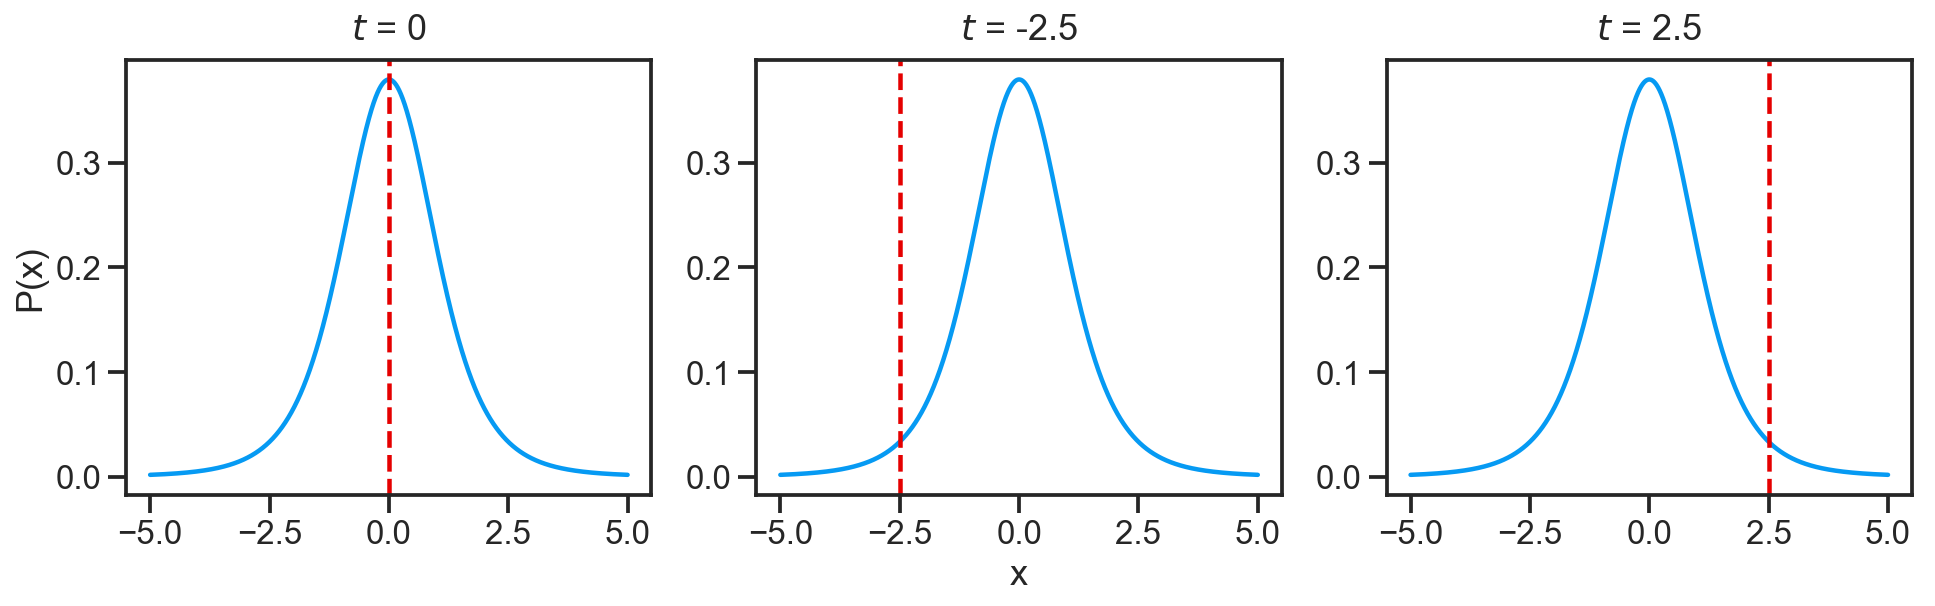

In [47]:
fig, ax = plt.subplots(figsize=(16,4))

plt.subplot(1, 3, 1)
lower_bound = -2.5
upper_bound = 2.5
length = 2000

x_axis = np.arange(-5, 5, 0.001)
df = 5
plt.plot(x_axis, stats.t.pdf(x_axis, df), color=sns.xkcd_rgb["azure"])
plt.axvline(x=0, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.ylabel("P(x)")
plt.title(f"$t$ = 0", pad=10)

plt.subplot(1, 3, 2)
plt.plot(x_axis, stats.t.pdf(x_axis, df), color=sns.xkcd_rgb["azure"])
plt.xlabel("x")
plt.axvline(x=-2.5, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.title(f"$t$ = -2.5", pad=10)

plt.subplot(1, 3, 3)
plt.plot(x_axis, stats.t.pdf(x_axis, df), color=sns.xkcd_rgb["azure"])
plt.axvline(x=2.5, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.title(f"$t$ = 2.5", pad=10)

plt.show()

### Step 4: Find Area Under t-distribution, based on $t$ statistic
Now, the foundation behind any hypothesis test is being able to take a test statistic from a specific sample and place it within the context of a known probability distribution. For t-tests, if you take a $t$-statistic and place it in the context of the correct $t$-distribution, you can calculate the probabilities associated with that $t$-statistic. 

A probability allows us to determine how common or rare our $t$-statistic is under the assumption that the null hypothesis is true. If the probability is low enough, we can conclude that the effect observed in our sample is inconsistent with the null hypothesis. The evidence in the sample data is strong enough to reject the null hypothesis for the entire population.

This will look similar to the problem of finding a confidence interval, seeing that want to find the area under the curve of a $t$-distribution:

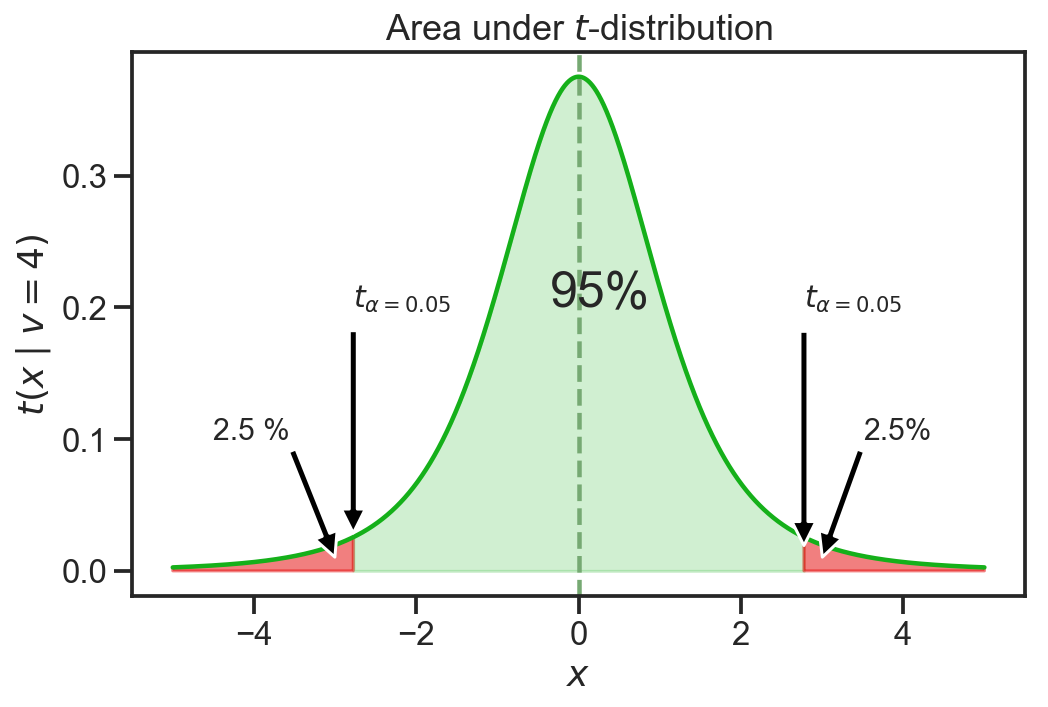

In [75]:
fig = plt.figure(figsize=(8, 5))   

lower_bound = -2.5
upper_bound = 2.5
length = 2000

mu = 0
sigma = 1
expected_mean = 1

x_axis = np.arange(-5, 5, 0.001)
df = 4
y = stats.t.pdf(x_axis, df)
plt.plot(x_axis, y, color=sns.xkcd_rgb["green"])
plt.axvline(x=0, color=sns.xkcd_rgb["dusty green"], linestyle="dashed")

t_pos = 2.776
t_neg = -2.776

plt.annotate(
    r'$t_{\alpha = 0.05}$',
    xy=(t_neg, 0.02),
    xytext=(t_neg, 0.2),
    arrowprops=dict(facecolor='black', shrink=0.05),
    size=15
)

plt.annotate(
    r'$t_{\alpha = 0.05}$',
    xy=(t_pos, 0.01),
    xytext=(t_pos, 0.2),
    arrowprops=dict(facecolor='black', shrink=0.05),
    size=15
)

plt.annotate(
    "2.5%",
    xy=(3, 0.01),
    xytext=(3.5, 0.1),
    arrowprops=dict(facecolor='black', shrink=0.005),
    size=15
)

plt.annotate(
    "2.5 %",
    xy=(-3, 0.01),
    xytext=(-4.5, 0.1),
    arrowprops=dict(facecolor='black', shrink=0.005),
    size=15
)

plt.annotate(
    '95%',
    [-0.35, 0.2],
    size=25
)

plt.title(f"Area under $t$-distribution")
plt.xlabel(f"$x$")
plt.ylabel(f"$t(x \mid v = 4)$")

plt.fill_between(x_axis, y, where=(y > stats.t.pdf(t_pos, df)), color=sns.xkcd_rgb["green"], alpha=0.2)
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t_neg, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.show()

Again, we are going to need the CDF. Also, remember that there are two tails of the distribution that we are going to need to consider, the left and the right. If we are at the extreme left, then our CDF will be very small and we will end up with a probability close to 0. If we are at the extreme right, then our CDF (area) will be very close to one. 

Hence, for a significance level of $\alpha = 0.05$, then we want to be be either in the bottom 2.5% of area on the left, or top 2.5% of area on the right. If that is the case, then we can say that the difference between our two groups is statistically significant. For this significance level, $t$ is known to have a threshold of $-2.776$ and $2.776$. 

At this point, we essentially have everything that we need in order to complete our testing! Depending on the value we determined for our $t$-statistic, we could end up with one of the scenarios below:

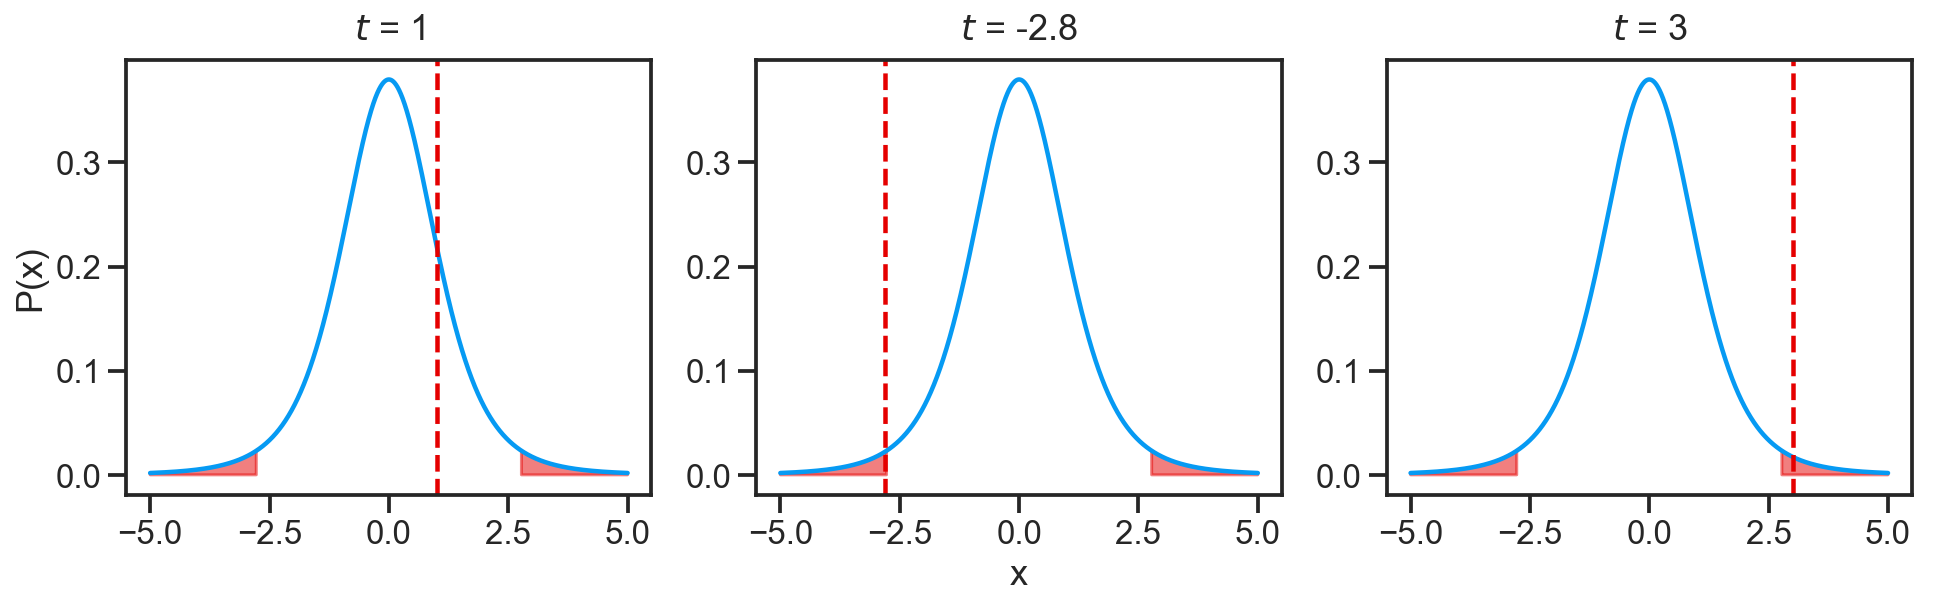

In [90]:
fig, ax = plt.subplots(figsize=(16,4))

plt.subplot(1, 3, 1)
lower_bound = -2.5
upper_bound = 2.5
length = 2000

x_axis = np.arange(-5, 5, 0.001)
df = 5

y = stats.t.pdf(x_axis, df)
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.axvline(x=1, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t_neg, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.ylabel("P(x)")
plt.title(f"$t$ = 1", pad=10)


plt.subplot(1, 3, 2)
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.xlabel("x")
plt.axvline(x=-2.8, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t_neg, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.title(f"$t$ = -2.8", pad=10)

plt.subplot(1, 3, 3)
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.axvline(x=3, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t_neg, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.title(f"$t$ = 3", pad=10)

plt.show()

Of which we would conclude the following result:
* Left Plot: The difference in means is not statistically significant. We _cannot_ reject the null hypothesis.
* Center Plot: The difference in means is statistically significant. We _can_ reject the null hypothesis.
* Right Plot: The difference in means is statistically significant. We _can_ reject the null hypothesis.

However, we are not done quite yet. We need to rephrase the above using a bit more statistics terminology. 

### P-Values
We just walked through how to determine if two groups are statistically significant or not. Now, the actual mechanical process is taken care of, however there is some additional terminology that we need to cover if we want to be able to follow along with modern statistics conversations. 

Our goal was to find one very small number, which is less than the significance level $\alpha$. In other words, we find a $t$-statistics, and then determine the amount of area under the curve that is contained based on its value. The small number has a specific name-that is the **p-value**! Now, there is a great deal of controversy over this tiny number, specifically that it is very subjective. It is formally defined as:

> **p-value**: The probability of obtaining a result equal to or _more extreme_ than what was actually observed, when the null hypothesis is true.

So, in terms of our example, if the average height men is equal to the average height of women (our null hypothesis), then the p-value is the probability of observing the difference we measured (or any larger difference). Visually, the p-value is equal the area shaded in red below. It is a function of our $t$-statistic; as $t$ becomes larger, the p-value should become smaller:

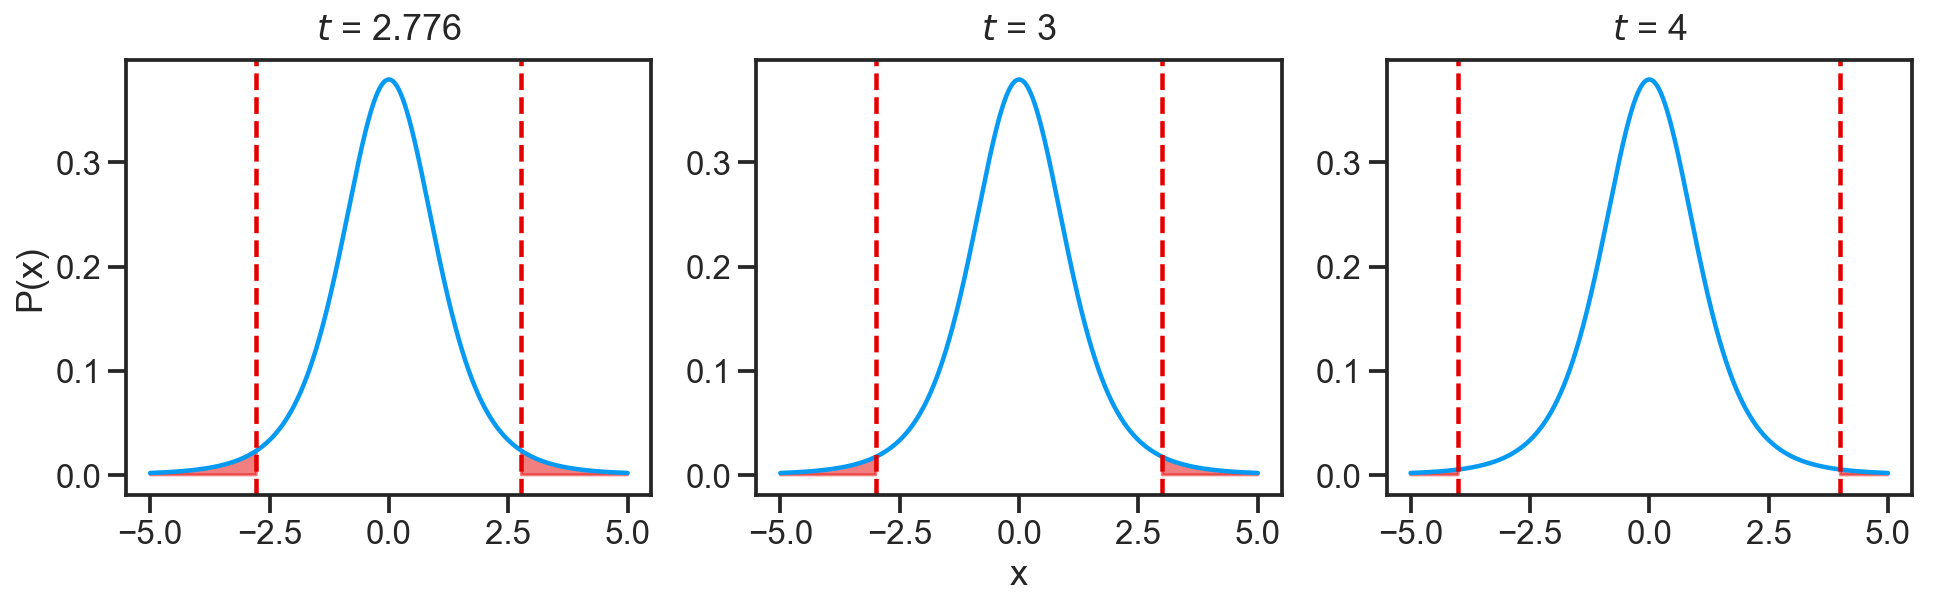

In [94]:
fig, ax = plt.subplots(figsize=(16,4))

plt.subplot(1, 3, 1)
lower_bound = -2.5
upper_bound = 2.5
length = 2000

x_axis = np.arange(-5, 5, 0.001)
df = 5
t_pos = 2.776
t_neg = -2.776
y = stats.t.pdf(x_axis, df)
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.axvline(x=t_pos, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.axvline(x=t_neg, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t_neg, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.ylabel("P(x)")
plt.title(f"$t$ = 2.776", pad=10)

plt.subplot(1, 3, 2)
t_pos = 3
t_neg = -3
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.xlabel("x")
plt.axvline(x=t_pos, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.axvline(x=t_neg, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t_neg, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.title(f"$t$ = 3", pad=10)

plt.subplot(1, 3, 3)
t_pos = 4
t_neg = -4
plt.plot(x_axis, y, color=sns.xkcd_rgb["azure"])
plt.axvline(x=t_pos, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.axvline(x=t_neg, color=sns.xkcd_rgb["red"], linestyle="dashed")
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t_neg, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.title(f"$t$ = 4", pad=10)

plt.show()

So, in general the following will happen:
1. We arrive at a p-value.
2. We check to see if our p-value is less than our significance level, $\alpha$.
3. If it is, we claim that the difference is statistically significant and we _reject the null hypothesis_.
4. Otherwise, we _cannot reject the null hypothesis_. This does _not_ mean that that null hypothesis is true, only that we cannot reject it based on the data that we collected. 

In the case of our example, we want our p-value to be less than 5%, which is a typical significance level. With the $t$-distribution CDF, that means that we will get a number less than 0.025 or greater than 0.975. If our number is greater than 0.975, we subtract it from 1, yielding a number less than 0.025. We finally multiply this number by (since there are two sides to the distribution), in order to yield our p-value. 

I want to note that we only multiply by two when conducting a two sided test. If we were conducting a one sided test, we are only checking if $\bar{X_1} > \bar{X_2}$, and we don't need to multiply by two because we are only interested in one tail. In this way, we say that the one sided test has more **power** than the two sided test, because it doesn't require a test statistic as extreme to be significant. 

In general, the more assumptions you make the more power your test has. The opposite is also true. The less assumptions we make, the less power our test has. 

### Testing Characteristics
Now that we know the process behind how to conduct a statistical test, I want to take a minute to go over some broad characteristics of our $t$-test, and testing in general. Let's look at the equation for our $t$-statistic again:

$$t = \frac{\bar{X_1} - \bar{X_2}}{s_p \sqrt{\frac{2}{N}}}$$

#### Relationship between $t$ and $N$
We know that if $\bar{X_1} >> \bar{X_2}$, or vice versa, $t$ will be larger. On the other hand, how does $t$ depend on $s_p$ and $N$? Well, because $N$ is effectively in the denominator of the denominator, we can see that:

$$t \propto \sqrt{N}$$

And likewise, $t$ is inversely proportional to $s_p$:

$$t \propto \frac{1}{s_p}$$

Putting that together, we arrive at:

$$t \propto \frac{\sqrt{N}}{s_p}$$

So, in other words as we collect more samples ($N$ grows), we get a larger $t$-statistic, and subsequently a smaller $p$ value. This means the for the exact same $\bar{X_1}$ and $\bar{X_2}$, a large $N$ may lead to a significant difference, while a small $N$ may not. 

#### Relationship between $t$ and $s_p$
Next, we can look at the standard deviation. This is saying that if the variance is large, it will be harder to find a statistically significant difference, due to too much overlap between the two groups, seen below:

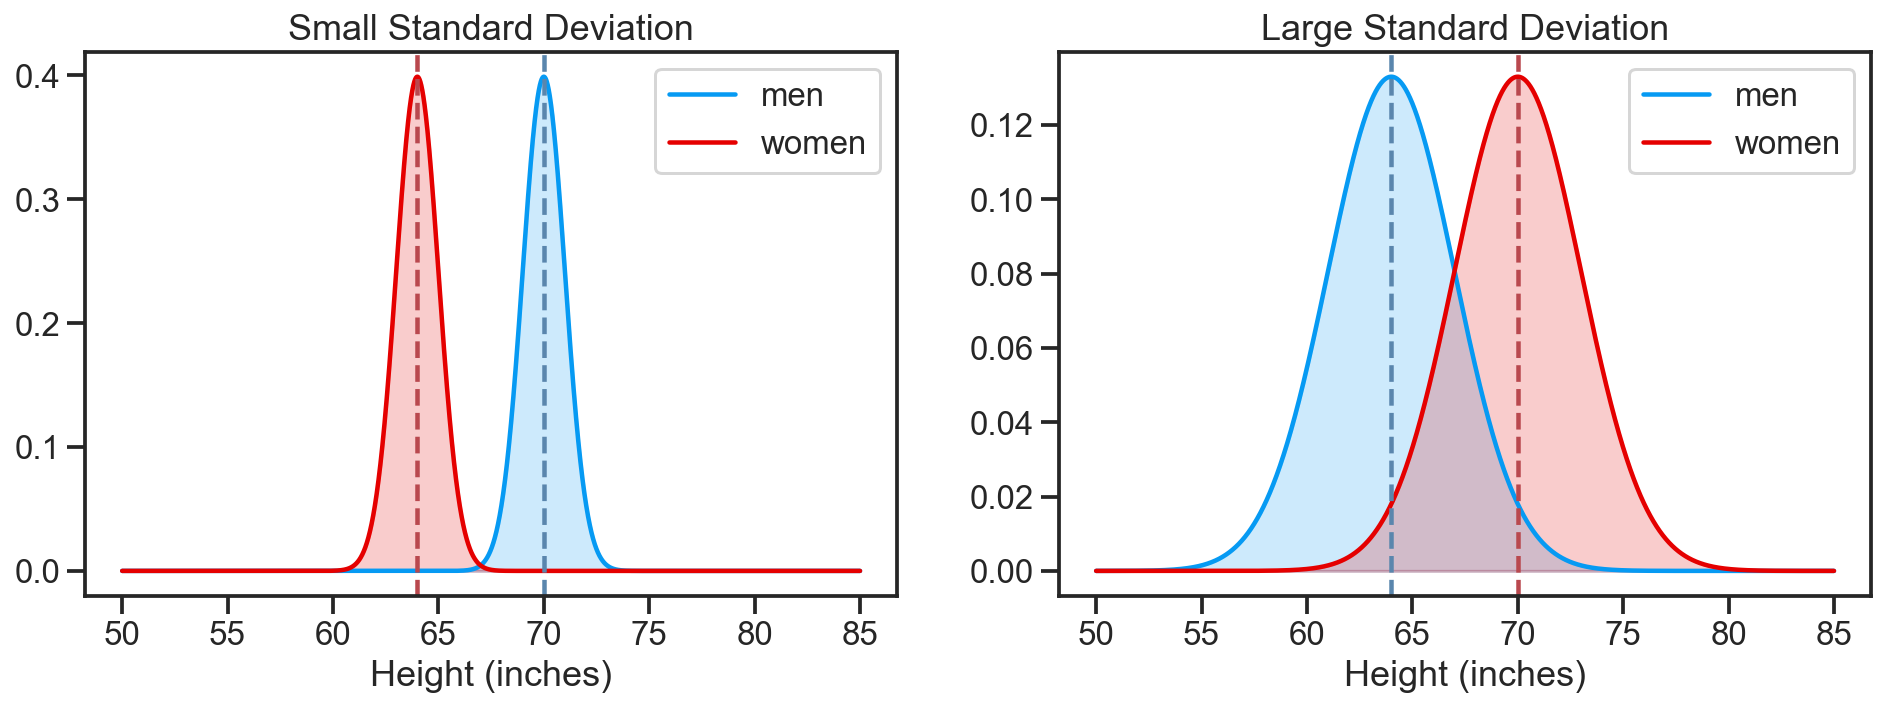

In [100]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(1, 2, 1)

lower_bound = 50
upper_bound = 85
length = 10000

mu_men = 70
mu_women = 64
sigma = 1

x_axis = np.arange(lower_bound, upper_bound, 0.001)

y_men = norm.pdf(x_axis, mu_men, sigma)
y_women = norm.pdf(x_axis, mu_women, sigma)

plt.plot(x_axis, y_men, color=sns.xkcd_rgb["azure"])
plt.plot(x_axis, y_women, color=sns.xkcd_rgb["red"])
plt.axvline(x=mu_men, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
plt.axvline(x=mu_women, color=sns.xkcd_rgb["dusty red"], linestyle="dashed")


plt.xlabel("Height (inches)")
plt.legend(['men', 'women'])
plt.title(r"Small Standard Deviation")

plt.fill_between(x_axis, y_men, color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.fill_between(x_axis, y_women, color=sns.xkcd_rgb["red"], alpha=0.2)

plt.subplot(1, 2, 2)

mu_men = 64
mu_women = 70
sigma = 3

x_axis = np.arange(lower_bound, upper_bound, 0.001)

y_men = norm.pdf(x_axis, mu_men, sigma)
y_women = norm.pdf(x_axis, mu_women, sigma)

plt.plot(x_axis, y_men, color=sns.xkcd_rgb["azure"])
plt.plot(x_axis, y_women, color=sns.xkcd_rgb["red"])
plt.axvline(x=mu_men, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
plt.axvline(x=mu_women, color=sns.xkcd_rgb["dusty red"], linestyle="dashed")


plt.xlabel("Height (inches)")
plt.legend(['men', 'women'])
plt.title(r"Large Standard Deviation")

plt.fill_between(x_axis, y_men, color=sns.xkcd_rgb["azure"], alpha=0.2)
plt.fill_between(x_axis, y_women, color=sns.xkcd_rgb["red"], alpha=0.2)

plt.show()

We can see above that we have same means in each plot (left and right), however the large variance on the right makes it harder to declare statistical significance. 

Next, let's look at how the test statistics changes with the pooled standard deviation, compared to $N$. This may very well remind you about the confidence interval. Recall, the standard deviation of the confidence interval was proportional to the standard deviation of the data, but only inversely proportional to the the square root of the sample size. Hence, we need a lot more data to account for a small increase in the standard deviation. 

We have the same situation with the test statistic-it only grows or becomes more extreme with  $\sqrt{N}$. At the same time, $t$ is inversely proportional to the standard deviation. So, if you are trying to find a significant difference, then you will need a lot more samples to account for small deviations in your data. 

#### Same variance assumption
Another thing that we assumed earlier was that the standard deviation of both groups is the same. This is a pretty strong assumption, one that is very likely to not be correct. What if they are in fact different? In that case we use **Welch's t-test**, which looks like: 

$$t = \frac{\bar{X_1} - \bar{X_2}}{s_{\bar{\Delta}}}$$

$$s_{\bar{\Delta}} = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$

The nice thing about the above is that our steps remain the same! We still:
1. Find our $t$-statistic
2. Find our degrees of freedom
3. Find the $p$-value to see if it is significant.

#### Gaussian Assumption
The final assumption that we made was that our data was gaussian distributed. In general, a lot of data that we will work with (including our click through rate data) is _not_ gaussian. We will see what type of test to use on click data shortly, but in general what should you do if you don't know what type of distribution your data comes from at all?

In that case, there are **nonparametric/distribution free tests** that do not make these assumptions. Some popular ones are:
* Kolmogorov-Smirnov test
* Kruskal-Wallis test
* Mann-Whitney U test

These can all be found in `scipy`. Similar to how `SKLearn` models have a `fit` and `predict` function, `scipy` will provide a similar API to work with. One thing to note about these nonparametric tests is that because they make less assumptions, they have less statistical power than if you had done something like a $t$-test:

$$\text{Less assumptions} \rightarrow \text{Less power} \rightarrow \text{Need more extreme difference for statistically significant p-value }$$

For those familiar with machine learning, this can be thought of in terms of providing your model with some prior knowledge, instead of letting it learn everything on it's own.

#### 1-sided vs. 2-sided tests
One final thing to note before moving on to our full example is the difference between 1 and 2 sided tests. In our example of the heights of men vs. women, we did not make the 1 sided assumption even though we could have (since we are positing that the height of men is greater than that of women, not simply that they are different). 

However, sometimes you don't want to just do a 1-sided test. For instance, imagine that you are drug testing-you want to test if a drug makes some condition better, but you alos want to test if it makes things worse! 

#### Summary
The point of this entire section was really to show how hypothesis testing works! We know that we start by generating a test statistic, from which we know it's distribution. We then look to see if it is at the _extreme_ values of the distribution, meaning that their is statistical significance. If there is statistical significance, then we can reject the null hypothesis.

## 5. Hypothesis Testing in Code

We are now going to walk through hypothesis testing in code. Note that in order to see all of the corresponding code you will need to click the toggle at the bottom of this page. 

We can start be generating our data. We will create two groups, `a` and `b`. `a` is going to be equal to gaussian distributed data of size `N`, with a mean of `2`. `b` is going to be the same thing, but with a mean of 0. Both `a` and `b` have a variance of 1. Visually, our data looks like:

In [93]:
N = 10

mean_a = 2
a = np.random.randn(N) + mean_a

mean_b = 0
b = np.random.randn(N) + mean_b

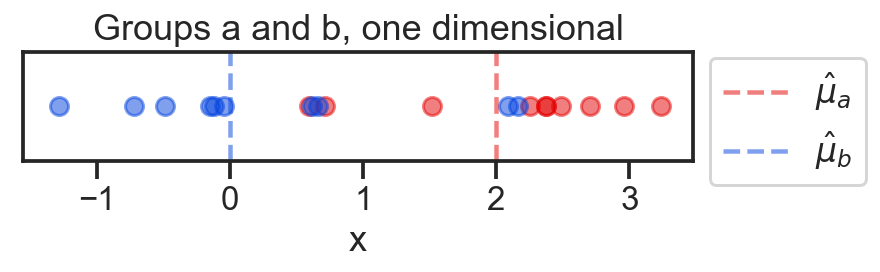

In [94]:
fig, ax = plt.subplots(figsize=(6,1))
y_val = np.zeros(len(a))

plt.scatter(a, y_val, alpha=0.5, color=sns.xkcd_rgb["red"])
plt.scatter(b, y_val, alpha=0.5, color=sns.xkcd_rgb["blue"])

ax.axvline(x=mean_a, color=sns.xkcd_rgb["red"], linestyle="dashed", alpha=0.5)
ax.axvline(x=mean_b, color=sns.xkcd_rgb["blue"], linestyle="dashed", alpha=0.5)

plt.legend([r"$\hat{\mu}_a$", "$\hat{\mu}_b$"], bbox_to_anchor=(1, 1.1))
plt.title("Groups a and b, one dimensional")
ax.set_yticks([])
plt.xlabel("x")
plt.show()

And to be clear, these group we randomly sampled from their respected gaussian distributions: 

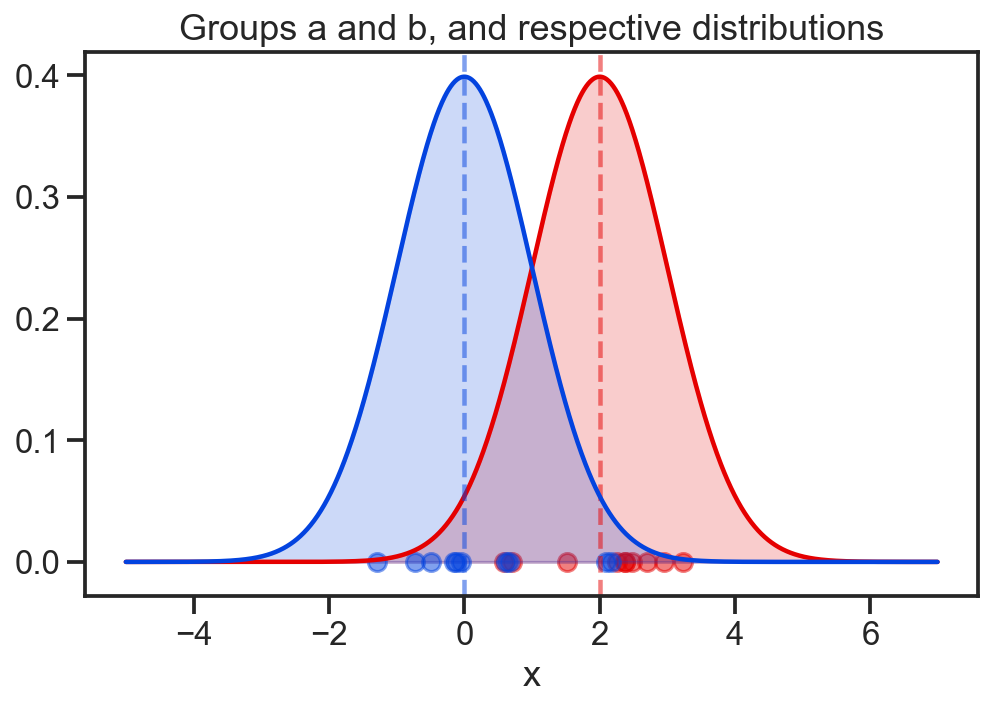

In [95]:
fig, ax = plt.subplots(figsize=(8,5))


x_axis = np.arange(-5, 7, 0.01)

# Group a
dist_a = norm.pdf(x_axis, mean_a, 1)
plt.plot(x_axis, dist_a, color=sns.xkcd_rgb["red"])
plt.fill_between(x_axis, dist_a,color=sns.xkcd_rgb["red"], alpha=0.2)
plt.scatter(a, y_val, alpha=0.5, color=sns.xkcd_rgb["red"])
ax.axvline(x=mean_a, color=sns.xkcd_rgb["red"], linestyle="dashed", alpha=0.5)

# Group b
dist_b = norm.pdf(x_axis, mean_b, 1)
plt.plot(x_axis, dist_b, color=sns.xkcd_rgb["blue"])
plt.fill_between(x_axis, dist_b, color=sns.xkcd_rgb["blue"], alpha=0.2)
plt.scatter(b, y_val, alpha=0.5, color=sns.xkcd_rgb["blue"])
ax.axvline(x=mean_b, color=sns.xkcd_rgb["blue"], linestyle="dashed", alpha=0.5)

plt.title("Groups a and b, and respective distributions")
plt.xlabel("x")

plt.show()

Our goal is to determine if groups `a` and `b` are statistically different. So, we will start by assuming that the null hypothesis is true, namely that there is no difference between groups `a` and `b`. Because of this assumption, we can use the $t$-statistic. The main goal of the $t$-statistic is boil down everything you see in the above plot into a single number! 

$$t = \frac{\bar{X_1} - \bar{X_2}}{s_p \sqrt{\frac{2}{N}}}$$

We can create our own $t$-test as follows:
* We want to calculate the variance of `a`
* By default `numpy` does the MLE of the variance (this can be done because we know the mean), which is dividing by `N`
* However, we want the unbiased estimate, so we will divide by `N-1`
* We then will do the same thing for variance of `b`

#### Calculate Variance

In [96]:
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)
print("Variance of a: ", var_a)
print("Variance of b: ", var_b)

Variance of a:  0.8065924020364057
Variance of b:  1.2855255481413232


#### Calculate Pooled Standard Deviation
Next, we will calculate the pooled standard deviation:

$$s_p = \sqrt{\frac{s_1^2 + s_2^2}{2}}$$

In [97]:
s = np.sqrt( (var_a + var_b)/2 )
print("Pooled standard deviation: ", s)

Pooled standard deviation:  1.02277024550427


#### Calculate $t$-statistic
And we can use that to in turn calculate our $t$-statistic:

In [98]:
t = (a.mean() - b.mean())/ (s * np.sqrt(2/N) )
print("t-statistic: ", t)

t-statistic:  4.044235250988252


#### Calculate Degrees of Freedom
Then the degress of freedom; when dealing with one group the degrees of freedom are equal to $N-1$. However, when we have two groups, `a` and `b`, there are two `N`'s to consider, so the degrees of freedom are:

$$df = (N_1 - 1) + (N_2 - 1)$$

In our case that is:

$$df = 2N - 2$$

In [99]:
df = 2*N - 2
print("Degrees of freedom: ", df)

Degrees of freedom:  18


Now that we have our $t$-statistic and degrees of freedom, we can see where our statistic lies on the $t$-distribution:

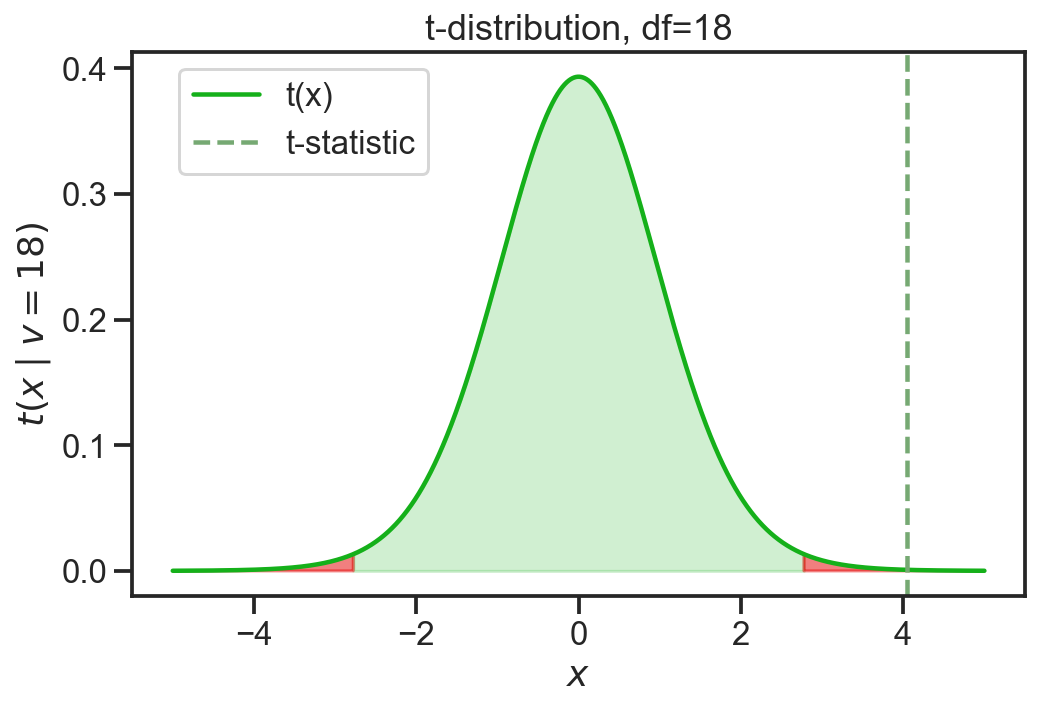

In [100]:
fig = plt.figure(figsize=(8, 5))   

x_axis = np.arange(-5, 5, 0.001)

y = stats.t.pdf(x_axis, df)
plt.plot(x_axis, y, color=sns.xkcd_rgb["green"])
plt.axvline(x=t, color=sns.xkcd_rgb["dusty green"], linestyle="dashed")

plt.title(f"t-distribution, df={df}")
plt.xlabel(f"$x$")
plt.ylabel(f"$t(x \mid v = {df})$")

plt.fill_between(x_axis, y, where=(y > stats.t.pdf(2.776, df)), color=sns.xkcd_rgb["green"], alpha=0.2)
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(-2.776, df)), color=sns.xkcd_rgb["red"], alpha=0.5)

plt.legend(["t(x)", "t-statistic"], bbox_to_anchor=(.35, 1))

plt.show()

Our $t$-statistic is clearly past the point of statistical significance; we can even zoom in to see the shaded are from $[0.975, 1]$:

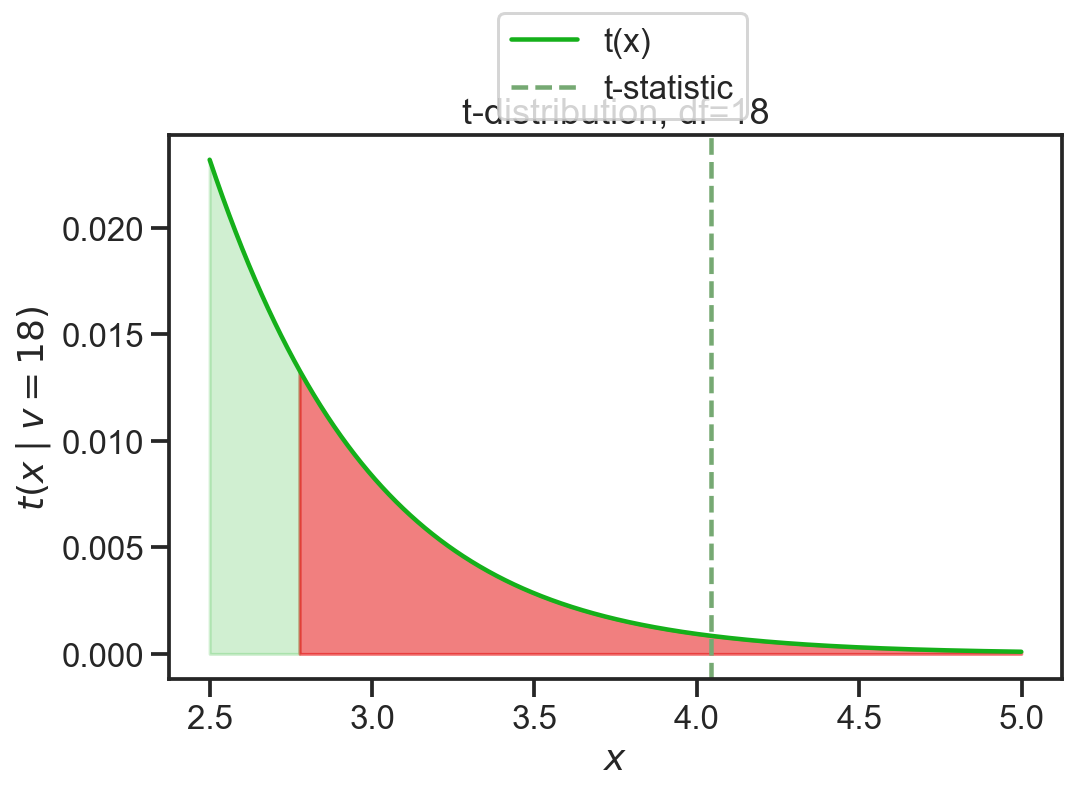

In [101]:
fig = plt.figure(figsize=(8, 5))   

x_axis = np.arange(2.5, 5, 0.001)

y = stats.t.pdf(x_axis, df)
plt.plot(x_axis, y, color=sns.xkcd_rgb["green"])
plt.axvline(x=t, color=sns.xkcd_rgb["dusty green"], linestyle="dashed")

plt.title(f"t-distribution, df={df}")
plt.xlabel(f"$x$")
plt.ylabel(f"$t(x \mid v = {df})$")

plt.fill_between(x_axis, y, where=(y > stats.t.pdf(2.776, df)), color=sns.xkcd_rgb["green"], alpha=0.2)
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(-2.776, df)), color=sns.xkcd_rgb["red"], alpha=0.5)

plt.legend(["t(x)", "t-statistic"], bbox_to_anchor=(.35, 1))

plt.show()

#### Calculate the $p$-value
Finally, we can calculate the $p$-value. `scipy` has a stats module that gives us access to the Student's T continuous random variable. We can use its `cdf` method in order to calculate how much of the area under the curve lies after our $t$-statistic:

In [102]:
p = 1 - stats.t.cdf(t, df=df)
print("t: ", t, "\tp: ", 2*p)

t:  4.044235250988252 	p:  0.0007610485517699495


#### Calculate the $p$-value with `scipy`'s built in function
The entire process that we just completed above can be compared to `scipys` build in `ttest_ind` function:

In [103]:
t2, p2 = stats.ttest_ind(a,b)
print("t2:", t2,"\tp2:", p2)

t2: 4.044235250988253 	p2: 0.0007610485517699772


## 6. $t$-test: Click through rate in code
Contrary to the previous lectures, we can in fact use a standard $t$-test even though clicks/no clicks (or buy/not buy) are not normally distributed. The reason we can still use a $t$-test is because their _means_ are approximately normal due the Central Limit Theorem (for a visualization of this in action look at my introduction to statistics post). This is a very crucial idea to keep in mind going forward, because it allows for probabilistic and statistical methods that work for normal distributions to be applicable to many problems involving other types of distributions.

### 6.1 Data File
To start, I want us to take a look at the data file we are going to be working with, `advertisement_clicks.csv`:

In [104]:
df = pd.read_csv("../../data/advertisement_clicks.csv")
df.head()

advertisement_id  action
0                B       1
1                B       1
2                A       0
3                B       0
4                A       1

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
advertisement_id    2000 non-null object
action              2000 non-null int64
dtypes: int64(1), object(1)
memory usage: 31.3+ KB


In [106]:
df.describe()

action
count  2000.000000
mean      0.338000
std       0.473147
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

So, the first column, `advertisement_id` tells us the advertisement that we are looking at (`A` or `B`). The second column, `action`, tells us whether the action was click of a no-click. Hence, for each row we know that the user has seen an advertisement, and a 1 means that they clicked on it, and a 0 means that they did not click on it. 

In total we have 2000 rows (historical examples), and overall we can see that our mean advertisement click rate is 0.338. 

I want to take a moment to make something very clear about this data; it doesn't matter where it came from! It could just as easily be about whether a user clicked on a news article headline instead of an advertisement. From a computational and statistical perspective, the scenario would be exactly the same! That is what is meant when I will sometimes mention that all data is the same. Of course I am not trying to declare that data from vastly different domains, gathered in different contexts, from different generating distributions is the same; rather that computational and statistical methods do no care (or even know about) the different of labels. Any two binary outcomes would be viewed as binary outcomes: buy vs. not buy, live vs. die, be cured vs. not vs. cured, and so on.

Let's dig into `A` and `B` a bit further:

In [107]:
df_a = df[df["advertisement_id"] == "A"]
df_b = df[df["advertisement_id"] == "B"]

In [108]:
print("Total clicks on advertisement A: ", df_a["action"].sum())
print("Total clicks on advertisement B: ", df_b["action"].sum())
print("\nMean clicks on advertisement A: ", df_a["action"].mean())
print("Mean clicks on advertisement B: ", df_b["action"].mean())

Total clicks on advertisement A:  304
Total clicks on advertisement B:  372

Mean clicks on advertisement A:  0.304
Mean clicks on advertisement B:  0.372


We can see that there does in fact seem to be a difference between the means of `A` and `B`! Let's try and get a visualization of this:

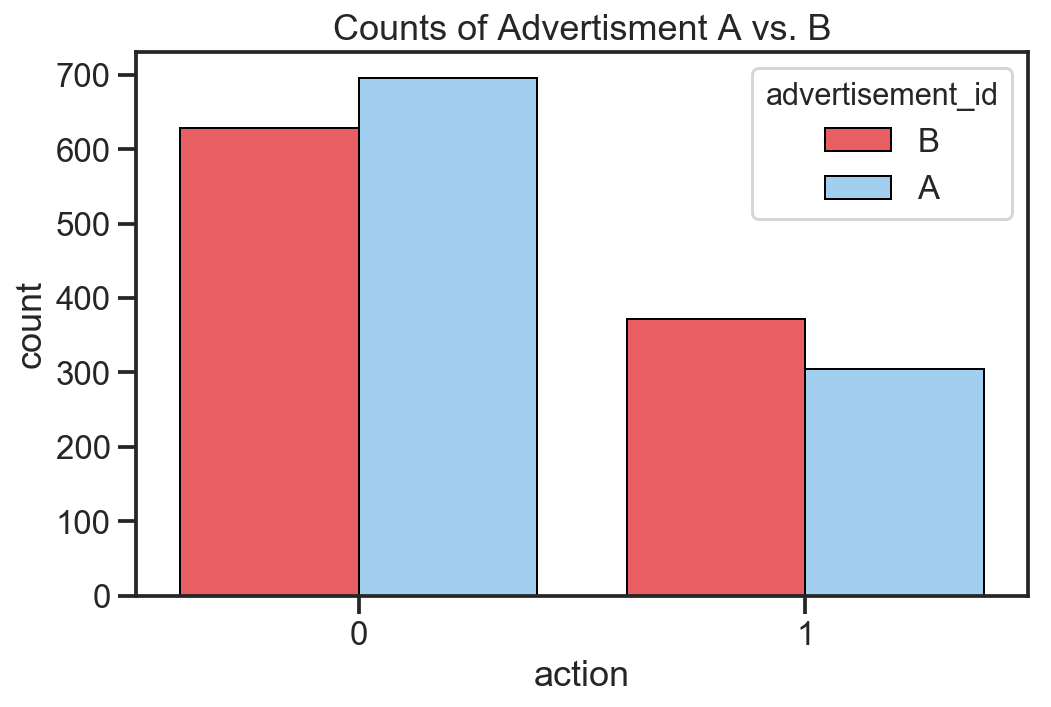

In [109]:
fig, ax = plt.subplots(figsize=(8,5))

ax = sns.countplot(
    x='action',
    hue='advertisement_id',
    data=df,
    palette=[sns.xkcd_rgb["light red"],sns.xkcd_rgb["light blue"]],
    edgecolor="black",
    linewidth=1,
)

ax.set_title("Counts of Advertisment A vs. B")
plt.show()

So, at this point we can see that there is a difference between advertisement `A` and `B`; specifically, `B` seems to have a higher click through rate compared to `A`. The question we need to ask if:

> Is the difference between CTR of advertisement `A` and `B` statistically significant? 

We know exactly how to do this! We just completed it in section 5 by using a hypothesis test! Specifically, we will need to:

<img src="https://drive.google.com/uc?id=1Zlz83SNwrovG5-I1wbMvK-CzsGFpzgB9" width="800">

Now, in this case we are going to be using **Welches t-test** because our variances are not the same:

$$t = \frac{\bar{X_1} - \bar{X_2}}{s_{\bar{\Delta}}}$$

$$s_{\bar{\Delta}} = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$

$$df = \frac{\big( \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}\big)^2 }{\frac{\big(\frac{s_1^2}{n_1}\big)^2}{n_1 - 1} + \frac{\big(\frac{s_2^2}{n_2}\big)^2}{n_2 - 1}}$$

#### Calculate Pooled Standard Deviation

In [110]:
N = df_a.shape[0]
s1 = df_a["action"].std()
s2 = df_b["action"].std()

s = np.sqrt( (np.power(s1,2)/N) + (np.power(s2,2)/N) )
print("Pooled Standard Deviation: ", s)

Pooled Standard Deviation:  0.0211103208323712


#### Determine our t-statistic

In [111]:
t = (df_a["action"].mean() - df_b["action"].mean()) / s
print("t-statistic: ", t)

t-statistic:  -3.2211732138019786


#### Calculate Degrees of Freedom - Needed for $t$-distribution

In [112]:
df_num = np.power(((np.power(s1,2)/N) + (np.power(s2,2)/N)), 2)
df_denom = (np.power(np.power(s1,2)/N,2)/(N-1)) + (np.power(np.power(s2,2)/N,2)/(N-1))
df = df_num / df_denom
print("Degrees of freedom for t-distribution: ", df)

Degrees of freedom for t-distribution:  1993.118753834377


#### Find where $t$-statistic falls along $t$-distribution
We now have our $t$-statistic and degrees of freedom, so we can plot our distribution and see where the $t$-statistic lies:

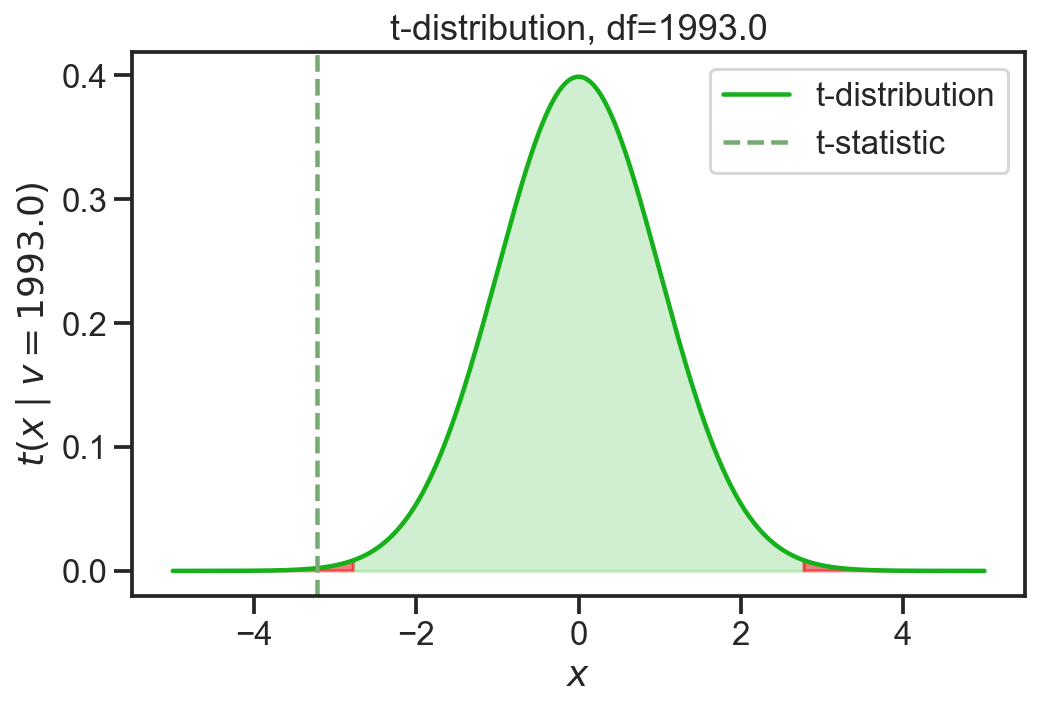

In [117]:
fig = plt.figure(figsize=(8, 5))   

x_axis = np.arange(-5, 5, 0.001)

y = stats.t.pdf(x_axis, df)
plt.plot(x_axis, y, color=sns.xkcd_rgb["green"])
plt.axvline(x=t, color=sns.xkcd_rgb["dusty green"], linestyle="dashed")

plt.title(f"t-distribution, df={round(df)}")
plt.xlabel(f"$x$")
plt.ylabel(f"$t(x \mid v = {round(df)})$")

plt.fill_between(x_axis, y, where=(y > stats.t.pdf(2.776, df)), color=sns.xkcd_rgb["green"], alpha=0.2)
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(-2.776, df)), color=sns.xkcd_rgb["red"], alpha=0.5)

plt.legend(["t-distribution", "t-statistic"])

plt.show()

#### Determine $p$-value
We can now determine our $p$-value, specifically the area under the curve to the left of our $t$-statistic. This area can be interpreted, in english, as:

> The probability that we would have observed the $t$-statistic that we did _if the null hypothesis was true_.

This probability is represented by the area shaded dark red, below:

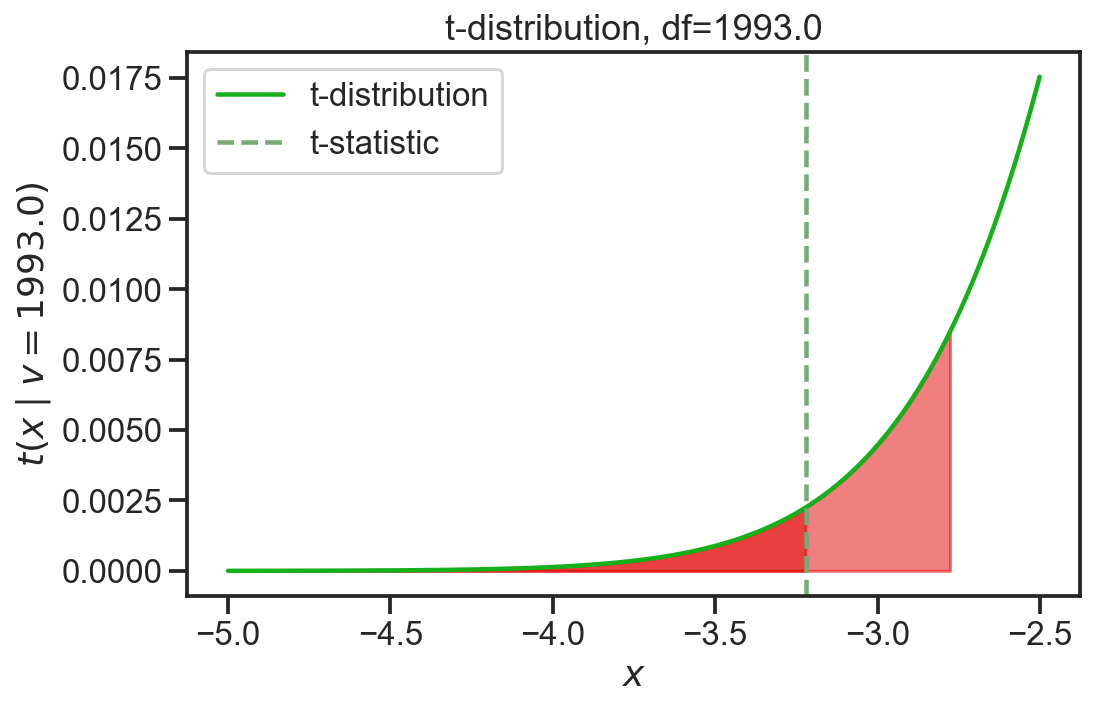

In [122]:
fig = plt.figure(figsize=(8, 5))   

x_axis = np.arange(-5, -2.5, 0.001)

y = stats.t.pdf(x_axis, df)
plt.plot(x_axis, y, color=sns.xkcd_rgb["green"])
plt.axvline(x=t, color=sns.xkcd_rgb["dusty green"], linestyle="dashed")

plt.title(f"t-distribution, df={round(df)}")
plt.xlabel(f"$x$")
plt.ylabel(f"$t(x \mid v = {round(df)})$")

plt.fill_between(x_axis, y, where=(y < stats.t.pdf(-2.776, df)), color=sns.xkcd_rgb["red"], alpha=0.5)
plt.fill_between(x_axis, y, where=(y < stats.t.pdf(t, df)), color=sns.xkcd_rgb["red"], alpha=0.5)

plt.legend(["t-distribution", "t-statistic"])

plt.show()

We can then calculate the $p$-value via the `scipy` stats module (since it gives us access to the student's T continuous random variable). We can use the `cdf` method in order to calculate how much of the area under the curve lies after our $t$-statistic:

In [124]:
p = stats.t.cdf(t, df=df)
print("t-statistic: ", t,"\tp-value:", 2*p)

t-statistic:  -3.2211732138019786 	p-value: 0.0012972410374001671


And we can of course compare with the built-in `scipy` function, `ttest_ind`:

In [126]:
t2, p2 = stats.ttest_ind(a,b)
print("t-statistic: ", t,"\tp-value:", 2*p)

t-statistic:  -3.2211732138019786 	p-value: 0.0012972410374001671


#### Conclusion
We arrived at a $p$-value that is equivalent to that of the scipy `ttest_ind` function! We can see that if the null hypothesis:
$$\mu_A = \mu_B$$
were true, our observations would have been made only 0.13% of the time. Because this is less than our significance level, $\alpha = 0.05$, we are able to reject the null hypothesis and say with confidence that advertisement `B` is more effective than advertisement `A`!

## 7. A/B Test for Click Through Rates (Chi-Squared Test)
At this point if you are only interested in hypothesis testing there is no need to continue, you have already covered the bulk of the important content. The remaining portion of this post focus's specifically on A/B testing for click through rates, and the some of it's nuances. 

We now know one hypothesis test ($t$-test), let's look at another (more complex) one. It is known as the **Chi-Squared Test**, and works for click through rates, and anything else that takes on a Bernoulli Distribution (not Gaussian). In other words, this test works for any categorical variable where we count things. We can see how it works by using a **contingency table:

|_______________|Click|No Click|
|----|----|----|
|Advertisement A|36|14|
|Advertisement B|30|25|

Our goal again is:

> To determine if the difference in click through rate between Advertisment A and B is statistically significant.

So, once we have the above contingency table, we calculate what is called the **Chi-Square Test Statistic**. 

### 7.1 Chi-Square Test Statistic
The $\chi^2$ test statistic gets it's name because it is chi-square distributed. This is similar to how the $t$-statistic is $t$-distributed. Like the $t$-distribution, the chi-square distributions main parameter is the degrees of freedom. Like $t$, it also have a location and scale, which is not listed in the wikipedia entry, but is available in `scipy` (with default: `loc = 0` and `scale = 1`).

The statistic is defined as follows:

$$\chi^2 = \sum_i \frac{(observed_i - expected_i)^2}{expected_i}$$

Where $i$ is equal to every cell of the table (4 in our current scenario). Specifically, the $i$ is used to index a call in the table. For example, at the start it is going to refer to (row 1, column 1):

$$i = (\text{Ad A}, \text{Click})$$

We can update our table to reflect the totals as well:

|_______________|Click|No Click|Click + No Click|
|----|----|----|----|
|Advertisement A|<span style="color:#0000cc; font-weight:bold" >36<span>|14|50|
|Advertisement B|30|25|55|
|Ad A + Ad B|66|39|105|

Here, the observed value is:

$$observed_i = 36$$

And the expected value is:

$$expected_i = (\text{Number of times Ad A is shown}) * p(click) = 50 * \frac{66}{105} = 31.429$$

Where:

$$p(click) = \frac{\text{Total number of clicks}}{\text{Total number of impressions}}$$

Similarly, if we wanted to estimate the number of no clicks for advertisement A:

|_______________|Click|No Click|Click + No Click|
|----|----|----|----|
|Advertisement A|36|<span style="color:#0000cc; font-weight:bold" >14<span>|50|
|Advertisement B|30|25|55|
|Ad A + Ad B|66|39|105|
    
Now, $i = (Ad A, no click)$. We can see that:

$$observed_i = 14$$

And the expected value:

$$expected_i = (\text{Number of times Ad A is shown}) * p(no \; click) = 50 * \frac{39}{105} = 18.571$$

$$p(click) = \frac{\text{Total number of no clicks}}{\text{Total number of impressions}}$$

So, we can go through the above process for all four cells in the contingency table, and use the chi-squared statistic equation to determine our final value. In this case is is:


$$\frac{(36-31.429)^2}{31.429}+\frac{(14-18.571)^2}{18.571}+\frac{(30-34.571)^2}{34.571}+\frac{(25-20.429)^2}{20.429} = 3.418$$

### 7.2 Chi-Square Distribution
Now that we have our test statistic, the next step is to place it in the context of it's corresponding distribution. Because the test statistic is always positive, and would get larger when the data strays from the average, a large chi-square test statistic would be significant. It will be extreme when _observed_ is far away from _expected_. Hence, if $\chi^2$ is large, $1 - CDF(\chi^2)$ will give us a small number. This small number is the $p$-value. As is typical, if $text{p-value} < \alpha$, then ad A and B are significantly different. 

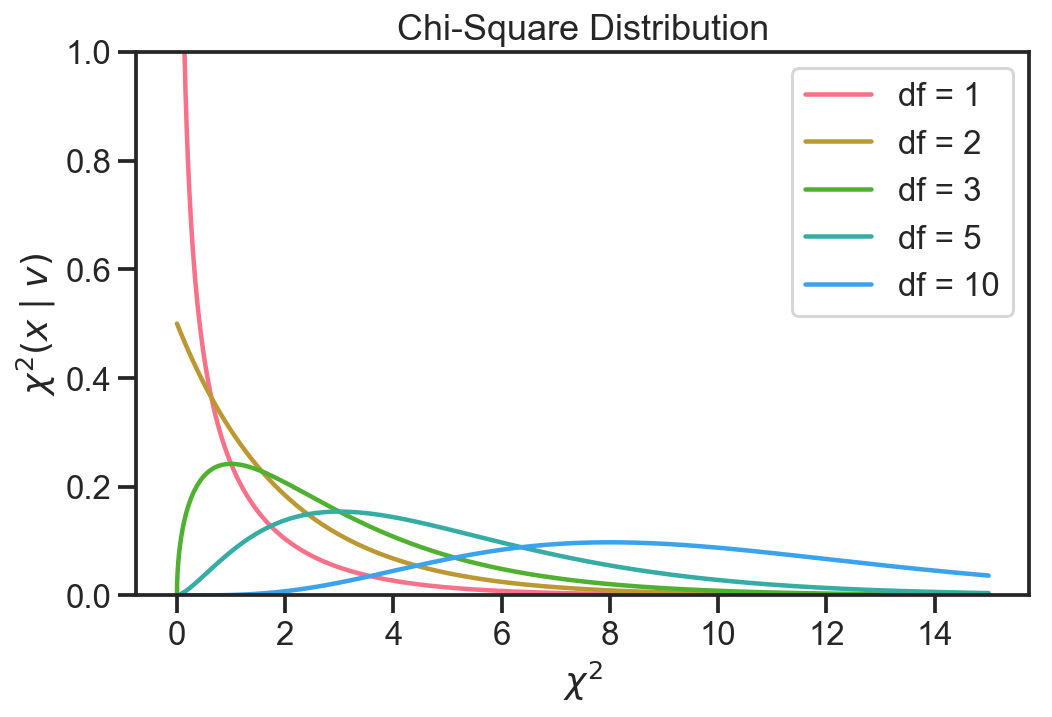

In [148]:
fig = plt.figure(figsize=(8, 5))   

x_axis = np.arange(0, 15, 0.001)

dfs = [1,2,3,5,10]
legend = []
for df in dfs:
    y = stats.chi2.pdf(x_axis, df)
    plt.plot(x_axis, y)
    legend.append(f"df = {df}")

plt.title(f"Chi-Square Distribution")
plt.xlabel(f"$\chi^2$")
plt.ylabel(f"$\chi^2(x \mid v)$")

plt.legend(legend)
plt.ylim(0,1)
plt.show()

Now, fortunately `scipy` has a built in process that will determine the chi-square statistic for us: `scipy.stats.chi2_contingency(Table, correction=False)`. You may wonder what exactly the `correction` parameter represents; well, to fully understand that we must realize that our chi-square test statistic asymptotically approachces the chi-square distribution (i.e. when $N = \infty$). This is the same situation as the Central Limit Theorem, aka the same situation we have when estimating the mean of a random variable. It will only be exact when $N=\infty$. So, there are slight statistical corrections that can be made to allow our answer to be more accurate. We won't delve into those corrections, since we risk missing the forest for the trees. 